In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt
import re #I import this library 'cause I need to deal with regular expressions
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder

# DATASET # SOBRE LA RELACIÓN ENTRE LA PUNTUACIÓN Y EL CONTENIDO DE LAS CRÍTICAS Y LOS GÉNEROS DEATH METAL

Mi objetivo es identificar y predecir el comportamiento de las puntuaciones de los críticos para los álbumes de death metal en función del género y el contenido del death metal.

Variables objetivo: Indicadores clave de rendimiento (KPI) que nos ayuden a mejorar la puntuación de la crítica de un álbum de death metal en relación con su contenido.
Fuente de datos https://www.kaggle.com/datasets/zhangjuefei/death-metal

----------------------------------------------------------------------------------------------------------------------------------------
Resumen:

Este proyecto de ciencia de datos se centra en el análisis de un conjunto de datos que comprende la información de bandas de Metal de todo el mundo y las críticas de sus discos. Particularmente, se presta atención al género del death metal, explorando si las bandas han cambiado a este género, se han alejado de él o se han mantenido consistentes con él a lo largo del tiempo.

Utilizando técnicas de análisis de datos, se llevó a cabo un procesamiento intensivo de los datos para permitir la comparación de las calificaciones promedio de los discos a lo largo del tiempo, con un enfoque especial en la transición de género de las bandas y su país de origen. El propósito de este análisis es descubrir correlaciones entre las transiciones de género, el promedio de las calificaciones de los discos y el país de origen de las bandas. Más allá de la simple correlación, también se busca descubrir relaciones de causalidad que puedan existir entre estos factores.

Finalmente, el objetivo final de este proyecto es evaluar la viabilidad de predecir la recepción crítica de los discos basándose en las transiciones de género en las bandas. Es decir, si los cambios creativos y las transiciones musicales en las bandas pueden ser un indicador de cómo serán recibidos sus discos. Este análisis tiene implicaciones significativas para comprender el impacto de la evolución creativa en la percepción crítica, así como para proporcionar una herramienta potencial para los artistas para navegar por su desarrollo creativo.

# Preguntas e hipótesis:

¿Las bandas que han hecho transiciones de género musical tienen una mayor variabilidad en las calificaciones de sus discos en comparación con las bandas que se han mantenido en un solo género? Esta hipótesis se basa en la idea de que los cambios de género pueden ser una estrategia de riesgo que puede resultar en mayores éxitos, pero también en mayores fracasos.

¿Existe una correlación entre el país de origen de una banda y su propensión a hacer transiciones de género? Esta pregunta surge de la hipótesis de que ciertos contextos culturales o de la industria musical pueden ser más propicios para las transiciones de género.

¿Es posible predecir la calificación de un disco basándose en si la banda ha hecho una transición de género y en su país de origen? Esta pregunta es la base de un modelo de predicción que podría ser útil para la industria de la música para anticipar la recepción de nuevos discos.








In [2]:
#Here I call the files of my second dataset in order to use it on the CoderHouse data science project
file1="bands.csv"
file2="reviews.csv"
file3="albums.csv"

#Here I read the csv files and define the dataframes
bands=pd.read_csv(file1)
reviews=pd.read_csv(file2)
albums=pd.read_csv(file3)

In [3]:
genre_df = pd.DataFrame(bands['genre'])
genre_df
pd.set_option('display.max_colwidth', None)

In [4]:
albums

,id,band,title,year
0,1,1,Taste the Hate,2014
1,2,3,The Bringer of Death,2014
2,3,4,Deception| Calculate What You Can't See,2005
3,4,7,Inti Huacay,1998
4,5,7,Génesis & horror,2002
...,...,...,...,...
28064,28065,37723,White Noise Paranormal,2010
28065,28066,37723,Anomalies of the Forest,2011
28066,28067,37723,Mother Earth Pantheon,2012
28067,28068,37723,Paganwinds,2014


# Normalización de datos

Aquí hago unos primeros pasos de estandarización de datos para extraer de un gráfico la información relevante:

Dentro del proceso de normalización y preparación de mis datos, inicié introduciendo una nueva columna booleana titulada "has_transitions" en el dataframe "bands". Esta columna se derivó de la presencia del carácter “|” en la columna "genero", que es utilizado para delinear la transición entre los géneros musicales que una banda ha interpretado desde sus inicios hasta el periodo final registrado en el dataset.

Para desglosar aún más este fenómeno de transición, utilicé funciones específicamente diseñadas para manejar expresiones regulares. A través de este método, pude segmentar las transiciones en tres categorías distintas. Esta segmentación resultó en la adición de dos columnas booleanas: "started_as_death" y "ends_as_death". Estas columnas me permiten identificar si una banda comenzó su trayectoria musical dentro del género death metal y posteriormente migró a otro género, o si, por el contrario, inició en un género distinto y eventualmente adoptó el death metal. Además, me permite identificar aquellas bandas que han permanecido fieles al death metal durante todo el periodo registrado.

Posteriormente, con el objetivo de analizar la recepción crítica de las bandas en relación a sus transiciones de género, empleé funciones de agregación en el dataframe "albums". Así, construí un nuevo dataframe que presenta la calificación promedio de toda la discografía de cada banda. Este proceso involucró una fusión entre los dataframes "bands" y "reviews", permitiendo un análisis más profundo y contextualizado de la relación entre transiciones de género y recepción crítica.

In [5]:
#Here I build a new boolean column named has_transitions which allows me to know which bands changes it genre from death metal to another genre or viceversa
bands['has_transitions']=bands['genre'].apply(lambda x: '|'in str(x))

In [6]:
# Here I change in all registers the term Death for Death Metal
bands['genre'] = bands.genre.apply(lambda x: str(x).replace('Metal','').replace('Death', 'Death Metal'))

Here I build a function to deal with regular expressions in the gender field, in order to determine if the death metal band started as a death metal band

In [7]:
def startAsDeath(x):
    patterns = [
                r"Death Metal.*?\|",  # Este patrón busca la cadena "Death Metal" seguida de cualquier número de cualquier carácter, hasta el primer "|".
               ]

    for pattern in patterns:
        match = re.search(pattern, x)
        if match is not None:  
            return True

    return False  




#Here I define the new columns I which I could know if the band started as a Death Metal Band
bands['started_as_death'] = bands.apply(lambda row: startAsDeath(str(row['genre'])) if row['has_transitions'] else False, axis=1)


In [8]:
bands['started_as_death'] = bands.apply(lambda row: True if row['genre'].strip() == 'Death Metal' else row['started_as_death'], axis=1)


In [9]:
false_count = bands['started_as_death'].value_counts()[False]


In [10]:
false_count

27163

In [11]:
true_count = bands['started_as_death'].value_counts()[True]


In [12]:
true_count

10560

Here I build another fuction in order to create another boolean that tells us if the band keeped doing death metal or it switches to another gender

In [13]:
def endstAsDeath(x):
    patterns = [
                r"\|(?=[^|]*$).*Death Metal",  
               ]

    for pattern in patterns:
        match = re.search(pattern, x)
        if match is not None:  
            return True

    return False  




#Here I define the new columns I which I could know if the band started as a Death Metal Band
bands['ends_as_death'] = bands.apply(lambda row: endstAsDeath(str(row['genre'])) if row['has_transitions'] else False, axis=1)

In [14]:
bands['ends_as_death'] = bands.apply(lambda row: True if row['genre'].strip() == 'Death Metal' else row['ends_as_death'], axis=1)

In [15]:
#Here I use the ipywidgets libraty to create filters in my dataframe
@interact
def filter_band(bandName=list(bands.name.unique())):
    return bands[bands.name==bandName]

interactive(children=(Dropdown(description='bandName', options=("('M') Inc.", '(sic)', '.F.O.A.D.', '100 Suns'…

In [16]:
@interact
def filter_transitions(bandTransition=list(bands.has_transitions.unique())):
    return bands[bands.has_transitions==bandTransition]

interactive(children=(Dropdown(description='bandTransition', options=(False, True), value=False), Output()), _…

In [17]:
@interact
def filter_started(bandStartedAs=list(bands.started_as_death.unique())):
    return bands[bands.started_as_death==bandStartedAs]

interactive(children=(Dropdown(description='bandStartedAs', options=(True, False), value=True), Output()), _do…

In [18]:
@interact
def filter_ended(bandEndsAs=list(bands.ends_as_death.unique())):
    return bands[bands.ends_as_death==bandEndsAs]

interactive(children=(Dropdown(description='bandEndsAs', options=(True, False), value=True), Output()), _dom_c…

# FUSIONAR LAS TABLAS
Aquí fusionaré las tablas para crear tres nuevos marcos de datos que contengan el nombre del grupo, el título del álbum, las puntuaciones y las booleanas

En esta sección creo una copia de la tabla reviews, y promedio las evaluaciones para cada disco.
Después de establecer la estructura inicial y realizar las transformaciones necesarias en el dataframe principal, me embarqué en la tarea de segmentar aún más la información. A partir del dataframe fusionado, creé tres dataframes distintos, cada uno reflejando un tipo específico de transición musical o consistencia en el género: las bandas que migraron al death metal, aquellas que se desplazaron del death metal a otro género, y las que siempre se mantuvieron en el death metal.

Con estos dataframes segmentados en mano, aproveché la capacidad de visualización interactiva que ofrece la librería ipywidgets. Establecí gráficos dinámicos que me permitieron realizar conteos de bandas basados en el score promedio otorgado por la crítica especializada a su discografía, todo esto categorizado por el país de origen de cada banda. A su vez, elaboré lineplots que representan las series de tiempo de los scores a lo largo de los años, lo que facilita la observación de tendencias y patrones según el país de procedencia de las bandas.

Para tener una comprensión aún más profunda y visual de los datos, diseñé raincloudplots que visualizan las distribuciones de los puntajes. Estos gráficos, aparte de mostrar la forma de las distribuciones de datos, resaltan de manera efectiva los datos atípicos y proporcionan una clara diferenciación por país de origen. Esta visualización fue fundamental para identificar las peculiaridades y tendencias particulares en las críticas de las bandas según su trayectoria y lugar de procedencia.

In [19]:
df_reviews=reviews.copy()
df_reviews.drop(columns=['content'],axis=1,inplace=True)

In [20]:
df_reviews_avg = df_reviews.groupby('album').agg({
    'id': 'first',  # Tomar el primer valor de 'id'
    'title': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Tomar el valor más frecuente de 'title'
    'score': 'mean'  # Calcular la media de 'score'
}).reset_index()

In [21]:
df_reviews_avg.loc[df_reviews_avg['album']==22369]


,album,id,title,score
5963,22369,14606,A Budding Flower Prematurely Plucked,0.832381


In [22]:
# Primer paso: fusionar las tablas bands y albums en base al id de la banda
bands_albums = pd.merge(bands, albums, left_on='id', right_on='band', suffixes=('_band', '_album'))




In [23]:
bandsReviews = pd.merge(bands_albums, df_reviews_avg, left_on='id_album', right_on='album')

In [24]:
bandsReviews.head(2)

,id_band,name,country,status,formed_in,genre,theme,active,has_transitions,started_as_death,ends_as_death,id_album,band,title_x,year,album,id,title_y,score
0,7,1917,Argentina,Active,1994.0,Death Metal,Dark Philosophical Poetry| Art| Religion| Psychology,1994-present,False,True,True,4,7,Inti Huacay,1998,4,1,The Killer Count Just Keeps Rising,0.88
1,7,1917,Argentina,Active,1994.0,Death Metal,Dark Philosophical Poetry| Art| Religion| Psychology,1994-present,False,True,True,5,7,Génesis & horror,2002,5,2,A gem of heterogeneous death metal...,0.96


In [25]:
bandsUnique=bandsReviews['id_band'].unique()

In [26]:
bandsUnique

array([    7,    32,    53, ..., 37718, 37719, 37723], dtype=int64)

In [27]:
bandsReviews.drop(['band','title_y','album'], axis=1,inplace=True)
bandsReviews.rename(columns={'title_x':'album_title'},inplace=True)

En esta sección creo tres dataframes que separan a las bandas dependiendo de que tipo de transiciones de genero realizaron

In [28]:
endsNotAsStartAs=bandsReviews[(bandsReviews['ends_as_death']==False) & (bandsReviews['started_as_death']==True)]

In [29]:
endsAsStartNotAs=bandsReviews[(bandsReviews['ends_as_death']==True) & (bandsReviews['started_as_death']==False)]

In [30]:
alwaysDeath=bandsReviews[(bandsReviews['has_transitions']==False)]

In [31]:
endsNotAsStartAs_avg = endsNotAsStartAs.groupby('id_band')['score'].mean().reset_index()
endsNotAsStartAs_avg    

,id_band,score
0,11143,0.500000
1,14768,0.770000
2,16693,0.860000
3,16950,0.783333
4,20572,0.550000
...,...,...
186,37709,0.410000
187,37713,0.622500
188,37714,0.812976
189,37719,0.880000


En esta sección defino unos nuevos dataframes dónde promedio los scores de los discos a lo largo de los años

In [32]:
df1_avg = endsNotAsStartAs.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'name': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'name'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'genre': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'genre'
    'album_title': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'album_title'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
}).reset_index()

In [33]:
endsAsStartNotAs_avg = endsAsStartNotAs.groupby('id_band')['score'].mean().reset_index()
endsAsStartNotAs_avg    

,id_band,score
0,16692,0.795000
1,28497,0.900000
2,28505,0.851120
3,28530,0.802083
4,29790,0.950000
...,...,...
111,37650,0.900000
112,37658,0.500000
113,37686,0.890000
114,37710,0.525167


In [34]:
df2_avg = endsAsStartNotAs.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'name': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'name'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'genre': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'genre'
    'album_title': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'album_title'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None  # Mantener el valor más común de 'year'
}).reset_index()

In [35]:
alwaysDeath_avg = alwaysDeath.groupby('id_band')['score'].mean().reset_index()
alwaysDeath_avg    

,id_band,score
0,7,0.890000
1,32,0.800000
2,53,0.920000
3,87,0.575000
4,93,0.780811
...,...,...
4011,37086,0.804167
4012,37124,0.000000
4013,37574,0.760000
4014,37591,0.733750


In [36]:
df3_avg = alwaysDeath.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'name': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'name'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'genre': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'genre'
    'album_title': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'album_title'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None  # Mantener el valor más común de 'year'
}).reset_index()

In [37]:
df3_avg.columns

Index(['id_band', 'score', 'name', 'country', 'genre', 'album_title', 'year'], dtype='object')

# Gráficas Individuales (Seaborn)

En esta sección, presentamos gráficos que ilustran la trayectoria de las calificaciones de los álbumes de bandas de Death Metal, considerando sus posibles transiciones entre géneros. Se examina si las bandas migraron desde o hacia el death metal, o si, por el contrario, se mantuvieron consistentemente dentro de este género durante su carrera. Las visualizaciones a continuación son histogramas que destacan el número de bandas según el puntaje promedio de sus álbumes, diferenciado por países.

In [38]:
@interact
def plotNotTransGender(country=list(df3_avg.country.unique())):
    filteredNotTrans = df3_avg[df3_avg.country == country]
    fig = sns.histplot(data=filteredNotTrans, x="score", bins=30,color='orange', edgecolor='red')
    plt.title('Average scores of death metal bands albums with no gender transitions')
    plt.show()


interactive(children=(Dropdown(description='country', options=('Argentina', 'United States', 'Finland', 'Brazi…

In [39]:
@interact
def plotTransGender(country=list(df2_avg.country.unique())):
    filteredTrans = df2_avg[df2_avg.country == country]
    fig = sns.histplot(data=filteredTrans, x="score", bins=30,color='orange', edgecolor='red')
    plt.title('Average scores of death metal bands albums that switched gender to death metal')
    plt.show()

interactive(children=(Dropdown(description='country', options=('Norway', 'Iceland', 'Sweden', 'Germany', 'Finl…

In [40]:
@interact
def plotJustDeath(country=list(df1_avg.country.unique())):
    filteredDeath = df1_avg[df1_avg.country == country]
    fig = sns.histplot(data=filteredDeath, x="score", bins=30,color='orange', edgecolor='red')
    plt.title('Average scores of death metal bands that switch from Death Metal to another metal gender')
    plt.show()

interactive(children=(Dropdown(description='country', options=('Australia', 'United States', 'France', 'German…

En esta sección presento series de tiempo que corresponden a la evolución temporal del promedio de los puntajes de discos de las bandas de DeathMetal

In [41]:
@interact
def plotScore(country=list(df3_avg.country.unique())):
    filteredNotTrans2 = df3_avg[df3_avg.country == country]
    fig = sns.lineplot(data=filteredNotTrans2, x="year", y="score", color='purple',ci=None)  
    plt.title('Score evolution for bands that has no gender transitions') 
    plt.xlabel('Año')  
    plt.ylabel('Score')  
    plt.show()


interactive(children=(Dropdown(description='country', options=('Argentina', 'United States', 'Finland', 'Brazi…

In [42]:
@interact
def plotScore(country=list(df2_avg.country.unique())):
    filteredTrans2 = df2_avg[df2_avg.country == country]
    fig = sns.lineplot(data=filteredTrans2, x="year", y="score", color='purple',ci=None)  
    plt.title('Score evolution of death metal bands albums that switched gender to death metal') 
    plt.xlabel('Year')  
    plt.ylabel('Score')  
    plt.show()

interactive(children=(Dropdown(description='country', options=('Norway', 'Iceland', 'Sweden', 'Germany', 'Finl…

In [43]:
@interact
def plotScore(country=list(df1_avg.country.unique())):
    filteredTrans3 = df1_avg[df1_avg.country == country]
    fig = sns.lineplot(data=filteredTrans3, x="year", y="score", color='purple',ci=None)  
    plt.title('Score evolution of death metal bands that switch from Death Metal to another metal gender') 
    plt.xlabel('Year')  
    plt.ylabel('Score')  
    plt.show()

interactive(children=(Dropdown(description='country', options=('Australia', 'United States', 'France', 'German…

In [44]:
@interact
def plotDistribution(country=list(df3_avg.country.unique())):
    filteredNotTrans = df3_avg[df3_avg.country == country]
    fig = sns.displot(data=filteredNotTrans, x="score", kde=True, color='#525FE1', edgecolor='magenta')  # utilizar el dataframe filtrado
    plt.title('Average scores of death metal bands albums with no gender transitions')
    plt.show()


interactive(children=(Dropdown(description='country', options=('Argentina', 'United States', 'Finland', 'Brazi…

# COMPARACIONES:

En esta sección muestro gráficas que establecen comparaciones en los puntajes y las distribuciones de los mismos para los casos en los cuales las bandas permanecieron haciendo Death Metal, cambiaron de Death Metal a otro género, o en defecto cambiaron de otro género al Death Metal

In [45]:
@interact
def plotScores(country=list(set(df1_avg.country.unique()).union(set(df2_avg.country.unique())).union(set(df3_avg.country.unique())))):
    filtered_df1 = df1_avg[df1_avg.country == country]
    filtered_df2 = df2_avg[df2_avg.country == country]
    filtered_df3 = df3_avg[df3_avg.country == country]

    sns.lineplot(data=filtered_df1, x="year", y="score", label='Switch gender', color='purple',ci=None)
    sns.lineplot(data=filtered_df2, x="year", y="score", label='Switch to death metal', color='blue',ci=None)
    sns.lineplot(data=filtered_df3, x="year", y="score", label='death metal', color='red',ci=None)

    plt.title('Scores over the years') 
    plt.xlabel('Year')  
    plt.ylabel('Score')
    plt.legend(title="Dataframes")
    plt.show()


interactive(children=(Dropdown(description='country', options=('Faroe Islands', 'Jordan', 'Pakistan', 'Sloveni…

# A continuación construyo algunos raincloudplots  para comparar las distribuciones en los distintos países

In [46]:
dfTest=df3_avg[['country','score']]

In [47]:
dfTest_Norway = dfTest[dfTest['country'] == 'Norway']


Here I build a rainclouplot for the score distribution on Norway for the case of bands that made no gender transition

In [48]:
dfTest_Country = dfTest[(dfTest['country'] == 'Norway') | (dfTest['country'] == 'Germany') | (dfTest['country'] == 'Sweden')]


Here I build a comparision between distributiosn in the scenario in witch bands does not made a gender switch for Sweden, Germany and Norway

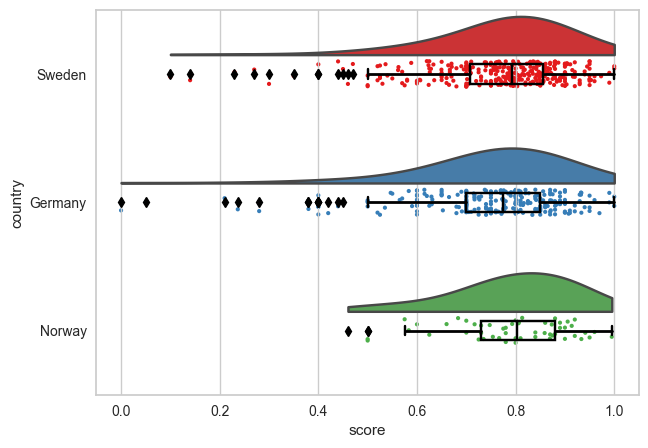

In [49]:
f, ax=plt.subplots(figsize=(7,5))
dy="country"; dx="score"; ort="h";pal="Set1"

ax=pt.half_violinplot(x=dx,y=dy,data=dfTest_Country,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data = dfTest_Country, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = dfTest_Country, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

Here I made thge same graph, but interactive

In [50]:
@interact
def countryfilter(country=list(df1_avg.country.unique())):

    dataframes = [df1_avg, df2_avg, df3_avg]
    titles = ['switch gender', 'switch to death metal', 'death metal']

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,7))

    for i, df in enumerate(dataframes):
        filtered_country = df[df.country == country]
        dy = "country"
        dx = "score"
        ort = "h"
        pal = "Set1"
        
        ax = pt.half_violinplot(x=dx, y=dy, data=filtered_country, palette=pal, bw=.6, cut=0., scale="area", width= .6, inner=None, orient=ort, ax=axes[i])
        ax = sns.stripplot( x = dx, y = dy, data = filtered_country, palette = pal, edgecolor = "white", size = 3, jitter = 1, zorder = 0, orient = ort, ax=axes[i])
        ax = sns.boxplot( x = dx, y = dy, data = filtered_country, color = "black",  width = .15, zorder = 10, showcaps = True, boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':2, "zorder":10}, saturation = 1, orient = ort, ax=axes[i])
        axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='country', options=('Australia', 'United States', 'France', 'German…

Este estudio reveló interesantes hallazgos sobre cómo la transición de género musical en las bandas de death metal es recibida, y cómo estos patrones varían dependiendo del país de origen de la banda. Como era de esperarse, cada país presentó una tendencia única en cuanto a la aceptación de estos cambios de género musical. Sin embargo, lo que resultó notable fue la regularidad observada en las distribuciones de los puntajes de los discos.

Las bandas que optaron por no cambiar de género musical mostraron en general una distribución unimodal en sus puntuaciones, con medianas cercanas a 0.8 sobre 1.0. Esta tendencia fue especialmente notoria en tres países de Europa que cuentan con una alta producción de música death metal. Esto sugiere que, al menos en estos países, las bandas que se mantienen fieles al género death metal tienden a recibir una recepción crítica sólida y consistente, con puntuaciones de discos predominantemente altas.

Es importante notar que este es un hallazgo inicial y que se necesitan más análisis para profundizar en estos patrones y explorar otras posibles influencias en las calificaciones de los discos. Sin embargo, estas primeras tendencias proporcionan una visión de cómo los cambios creativos en las bandas de death metal son recibidos en diferentes contextos y establecen la base para investigaciones futuras sobre este tema.

# Calculo de la probabilidad de obtener scores superiores

En esta sección procedo a calcular la probabilidad de que las bandas de los diferentes paises del mundo tengan una califiación mayor a 0.7 sobre 1.0 y realizo la comparación segmentando los datos por pais y establenciendo comparaciones entre bandas que hacen transiciones y las que no las hacen.

Probabilidad de obtener diferentes scores dependiendo del tipo de transición de genero

In [51]:
@interact
def plotStackedDistributions(country=list(df1_avg.country.unique())):
    filtered_df1 = df1_avg[df1_avg.country == country]
    filtered_df2 = df2_avg[df2_avg.country == country]
    filtered_df3 = df3_avg[df3_avg.country == country]

    sns.histplot(data=filtered_df1, x="score", color="blue", label="Switch gender", multiple="stack", stat="probability", bins=30)
    sns.histplot(data=filtered_df2, x="score", color="magenta", label="Switch to death metal", multiple="stack", stat="probability", bins=30)
    sns.histplot(data=filtered_df3, x="score", color='orange', edgecolor='red', label="death metal", multiple="stack", stat="probability", bins=30,alpha=0.3)

    plt.title('Average scores of death metal bands albums')
    plt.legend(title="Bands behavior")
    plt.show()


interactive(children=(Dropdown(description='country', options=('Australia', 'United States', 'France', 'German…

# En esta sección efectuó algunos cálculos para fijar rangos en el cálculo de la probabilidad de obtener scores superiores

In [52]:
df1_avg['score'].mean()

0.7695528002123436

In [53]:
df1_avg['score'].std()

0.15992657173325128

In [54]:
df2_avg['score'].mean()

0.7513852810544371

In [55]:
df2_avg['score'].std()

0.16215213651609964

In [56]:
df3_avg['score'].mean()

0.7621270180248174

In [57]:
df3_avg['score'].std()

0.15335684449957038

In [58]:
df3_avg.quantile(0.90)

id_band    33753.50
score          0.91
year        2014.00
Name: 0.9, dtype: float64

In [59]:
df3_avg.quantile(0.25)

id_band    10087.75
score          0.70
year        2002.00
Name: 0.25, dtype: float64

In [60]:
def probability(year):
    conteo = ((df3_avg['score'] > 0.8) & (df3_avg['year'] == year)).sum()
    total = len(df3_avg[df3_avg['year'] == year])
    p = conteo / total*100
    return p


In [61]:
probability(1998)

46.25

# En esta sección creo listas de paises y años unicos para cada tipo de transición con el objetivo de definir las funciones de probabilidad

In [62]:
countries1=df1_avg['country'].unique()
years1=df1_avg['year'].unique()
countries2=df2_avg['country'].unique()
years2=df2_avg['year'].unique()
countries3 = df3_avg['country'].unique()
years3 = df3_avg['year'].unique()


# Funciones de probabilidad de obtener scores en el segundo cuartil dependiendo del año y el país

In [63]:
def probability1(country, year):
    total_scores = len(df1_avg[(df1_avg['year'] == year) & (df1_avg['country'] == country)])
    high_scores = len(df1_avg[(df1_avg['year'] == year) & (df1_avg['country'] == country) & (df1_avg['score'] >= 0.61) & (df1_avg['score']<=0.93)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability2(country, year):
    total_scores = len(df2_avg[(df2_avg['year'] == year) & (df2_avg['country'] == country)])
    high_scores = len(df2_avg[(df2_avg['year'] == year) & (df2_avg['country'] == country) & (df2_avg['score'] >= 0.61) & (df2_avg['score']<=0.93)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability3(country, year):
    total_scores = len(df3_avg[(df3_avg['year'] == year) & (df3_avg['country'] == country)])
    high_scores = len(df3_avg[(df3_avg['year'] == year) & (df3_avg['country'] == country) & (df3_avg['score'] >= 0.61) & (df1_avg['score']<=0.93)])
    return high_scores / total_scores if total_scores > 0 else 0

data1 = []
for country in countries1:
    for year in years1:
        data1.append({
            'year': year,
            'country': country,
            'probability': probability1(country, year)
        })

df_probability1 = pd.DataFrame(data1)


data2 = []
for country in countries2:
    for year in years2:
        data2.append({
            'year': year,
            'country': country,
            'probability': probability2(country, year)
        })

df_probability2 = pd.DataFrame(data2)

data3 = []
for country in countries3:
    for year in years3:
        data3.append({
            'year': year,
            'country': country,
            'probability': probability3(country, year)
        })

df_probability3 = pd.DataFrame(data3)

En esta sección defino funciones para contar la cantidad de puntuaciones emitidas por la crítica especializada a las bandas según el tipo de transición de género que han efectuado teniendo en cuenta la calificación media de la discográfia de las bandas

In [64]:
def scoreCount1(country):
    scoreLen1=len(df1_avg[df1_avg['country']==country])
    return scoreLen1
def scoreCount2(country):
    scoreLen2=len(df2_avg[df2_avg['country']==country])
    return scoreLen2
def scoreCount3(country):
    scoreLen3=len(df3_avg[df3_avg['country']==country])
    return scoreLen3

lenData1=[]
for country in countries1:
    lenData1.append({
    'country':country,
    'count': scoreCount1(country)    
    })
df_len1=pd.DataFrame(lenData1)    

lenData2=[]
for country in countries1:
    lenData2.append({
    'country':country,
    'count': scoreCount2(country)    
    })
df_len2=pd.DataFrame(lenData2)    

lenData3=[]
for country in countries1:
    lenData3.append({
    'country':country,
    'count': scoreCount3(country)    
    })
df_len3=pd.DataFrame(lenData3)    

In [65]:
scoreCount1('France')

5

In [66]:
df_len3

,country,count
0,Australia,130
1,United States,1002
2,France,115
3,Germany,256
4,Mexico,59
5,Russia,110
6,Azerbaijan,0
7,Spain,89
8,Israel,14
9,Sweden,330


# Probabilidades de obtener scores superiores a 0.75

En esta sección y despúes de observar los resultados para el 90 percentil, defino funciones de probabilidad de obtener scores superiores a 0.75 dependiendo del país de procedencia.

In [67]:
def probability1R(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount1(country)>=5:
        total_scores = len(df1_avg[df1_avg['country'] == country])
        high_scores = len(df1_avg[(df1_avg['country'] == country) &  (df1_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan

def probability2R(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount2(country)>=5:
        total_scores = len(df2_avg[df2_avg['country'] == country])
        high_scores = len(df2_avg[(df2_avg['country'] == country) & (df2_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan
def probability3R(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount3(country)>=5:
        total_scores = len(df3_avg[df3_avg['country'] == country])
        high_scores = len(df3_avg[(df3_avg['country'] == country) &  (df3_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan


data1R = []
for country in countries1:
        data1R.append({
            'country': country,
            'probability_ed': probability1R(country)
        })

df_probability1R = pd.DataFrame(data1R)
df_probability1R = df_probability1R.dropna(subset=['probability_ed'])


data2R = []
for country in countries2:
        data2R.append({
            'country': country,
            'probability_ed': probability2R(country)
        })

df_probability2R = pd.DataFrame(data2R)
df_probability2R = df_probability2R.dropna(subset=['probability_ed'])

data3R = []
for country in countries3:
        data3R.append({
            'country': country,
            'probability_ed': probability3R(country)
        })

df_probability3R = pd.DataFrame(data3R)
df_probability3R = df_probability3R.dropna(subset=['probability_ed'])

In [68]:
df_probability3R

,country,probability_ed
0,Argentina,0.565217
1,United States,0.679641
2,Finland,0.691099
3,Brazil,0.609195
4,Belgium,0.695652
5,Australia,0.684615
6,Sweden,0.693939
7,Germany,0.613281
8,Greece,0.647059
9,Netherlands,0.700935


# Ojo
en esta sección las funciones de probabilidad probabilityied están definidas sin tener en cuenta que hay países con conteos muy bajos lo cual produce ruido en los datos
por lo que opte por solo mantener los resultados asociados a las funciones de probabilidad probabilityiR que si tienen en cuenta este aspecto

In [69]:
def probability1ed(country):
    total_scores = len(df1_avg[df1_avg['country'] == country])
    high_scores = len(df1_avg[(df1_avg['country'] == country) &  (df1_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability2ed(country):
    total_scores = len(df2_avg[df2_avg['country'] == country])
    high_scores = len(df2_avg[(df2_avg['country'] == country) & (df2_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability3ed(country):
    total_scores = len(df3_avg[df3_avg['country'] == country])
    high_scores = len(df3_avg[(df3_avg['country'] == country) &  (df3_avg['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else 0

def probability1in(country):
    total_scores = len(df1_avg[df1_avg['country'] == country])
    high_scores = len(df1_avg[(df1_avg['country'] == country) &  (df1_avg['score']<=0.7)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability2in(country):
    total_scores = len(df2_avg[df2_avg['country'] == country])
    high_scores = len(df2_avg[(df2_avg['country'] == country) & (df2_avg['score']<=0.7)])
    return high_scores / total_scores if total_scores > 0 else 0
def probability3in(country):
    total_scores = len(df3_avg[df3_avg['country'] == country])
    high_scores = len(df3_avg[(df3_avg['country'] == country) &  (df3_avg['score']<=0.7)])
    return high_scores / total_scores if total_scores > 0 else 0

data1ed = []
for country in countries1:
        data1ed.append({
            'country': country,
            'probability_ed': probability1ed(country),
            'probability_in':probability1in(country)
        })

df_probability1ed = pd.DataFrame(data1ed)


data2ed = []
for country in countries2:
        data2ed.append({
            'country': country,
            'probability_ed': probability2ed(country),
            'probability_in':probability2in(country)
        })

df_probability2ed = pd.DataFrame(data2ed)

data3ed = []
for country in countries3:
        data3ed.append({
            'country': country,
            'probability_ed': probability3ed(country),
            'probability_in':probability3in(country)
        })

df_probability3ed = pd.DataFrame(data3ed)

In [70]:
df_probability1['year'] = pd.to_numeric(df_probability1['year'], errors='coerce')
df_probability2['year'] = pd.to_numeric(df_probability2['year'], errors='coerce')
df_probability3['year'] = pd.to_numeric(df_probability3['year'], errors='coerce')


# Barplot del top 10 de paises, según la probabilidad de obtener un score en el 90 percentil si la banda siempre hizo death metal

<AxesSubplot: xlabel='probability_ed', ylabel='country'>

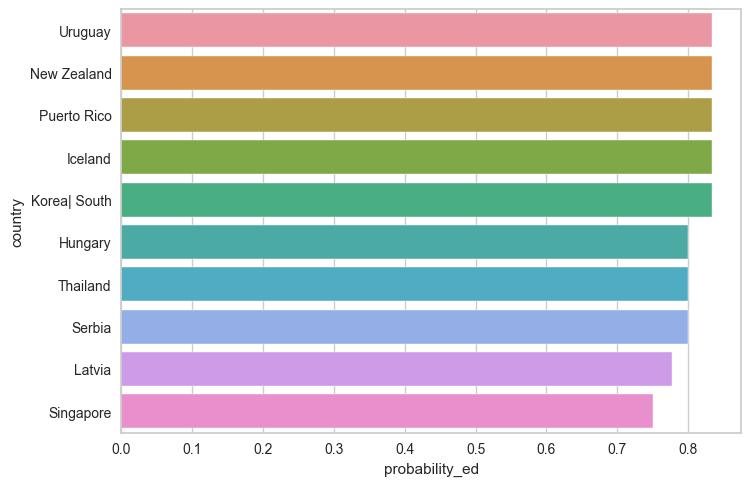

In [71]:
top_10_countries = df_probability3R.nlargest(10, 'probability_ed')
sns.barplot(x='probability_ed', y='country', data=top_10_countries)


# Barplot del top 10 de paises, según la probabilidad de obtener un score en el 90 percentil si la banda NO termino haciendo death metal

<AxesSubplot: xlabel='probability_ed', ylabel='country'>

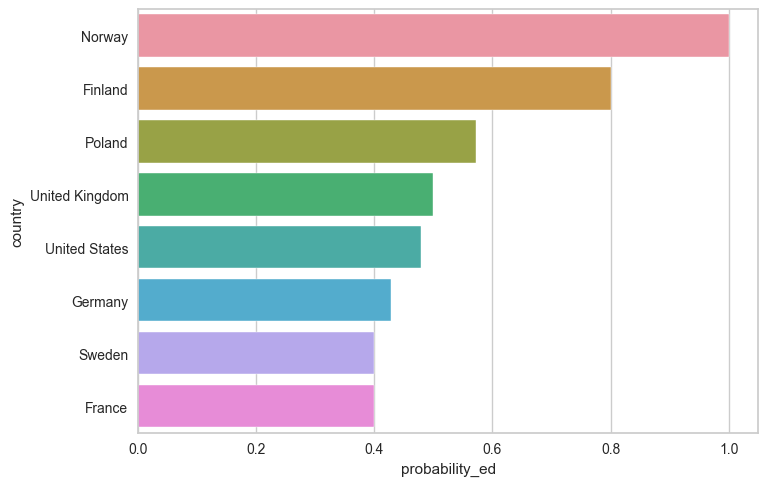

In [72]:
top_10_countries2 = df_probability2R.nlargest(10, 'probability_ed')
sns.barplot(x='probability_ed', y='country', data=top_10_countries2)

# Barplot del top 10 de paises, según la probabilidad de obtener un score en el 90 percentil si la banda termino haciendo death metal

<AxesSubplot: xlabel='probability_ed', ylabel='country'>

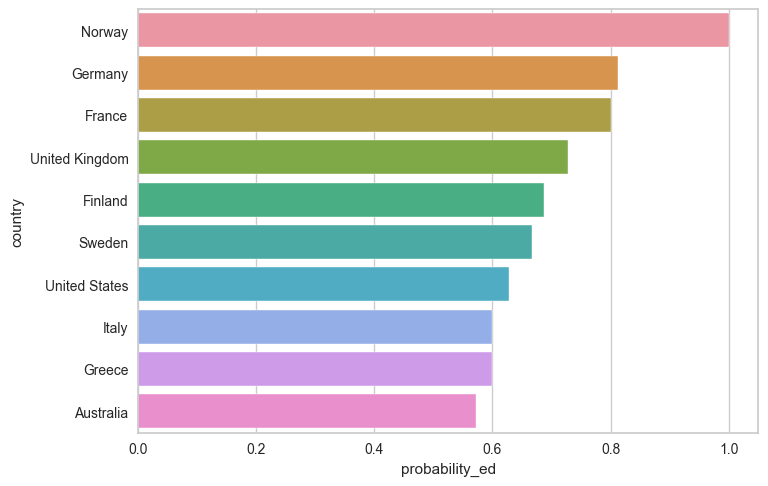

In [73]:
top_10_countries1 = df_probability1R.nlargest(10, 'probability_ed')
sns.barplot(x='probability_ed', y='country', data=top_10_countries1)

In [74]:
df_probability1ed['type']=1
df_probability2ed['type']=2
df_probability3ed['type']=3

In [75]:
df_probability1R['type']=1
df_probability2R['type']=2
df_probability3R['type']=3

In [76]:
df_probability1ed.columns


Index(['country', 'probability_ed', 'probability_in', 'type'], dtype='object')

In [77]:
numero_de_nulos = df_probability2ed['probability_ed'].isna().sum()
numero_de_nulos

0

In [78]:
df_probability3ed

,country,probability_ed,probability_in,type
0,Argentina,0.565217,0.304348,3
1,United States,0.679641,0.242515,3
2,Finland,0.691099,0.246073,3
3,Brazil,0.609195,0.298851,3
4,Belgium,0.695652,0.217391,3
...,...,...,...,...
96,Unknown,1.000000,0.000000,3
97,Kuwait,1.000000,0.000000,3
98,Uzbekistan,1.000000,0.000000,3
99,Kazakhstan,0.000000,0.000000,3


In [79]:
df_probabilityConcat=pd.concat([df_probability1ed, df_probability2ed, df_probability3ed], ignore_index=True)

In [80]:
df_probabilityConcatR=pd.concat([df_probability1R, df_probability2R, df_probability3R], ignore_index=True)

In [81]:
df_probabilityConcatR

,country,probability_ed,type
0,Australia,0.571429,1
1,United States,0.628571,1
2,France,0.800000,1
3,Germany,0.812500,1
4,Russia,0.571429,1
...,...,...,...
71,Croatia,0.400000,3
72,Serbia,0.800000,3
73,Korea| South,0.833333,3
74,Bosnia and Herzegovina,0.600000,3


In [82]:
df_probabilityConcat

,country,probability_ed,probability_in,type
0,Australia,0.571429,0.285714,1
1,United States,0.628571,0.200000,1
2,France,0.800000,0.200000,1
3,Germany,0.812500,0.187500,1
4,Mexico,1.000000,0.000000,1
...,...,...,...,...
174,Unknown,1.000000,0.000000,3
175,Kuwait,1.000000,0.000000,3
176,Uzbekistan,1.000000,0.000000,3
177,Kazakhstan,0.000000,0.000000,3


# En esta sección trabajo con la construcción de dataframes que incluyan el conteo de discos producidos por las bandas para correr algoritmos de clasificación y clustering

En esta sección se implementan algoritmos supervisados y no supervisados( vecinos cercanos y arboles de decisión, clustering por k-means) con el fin de encontrar las curvas de decisión en términos del número de discos producidos por las bandas y el año de formación de las  mismas. Se observa una clasificación y la definición de las curvas de decisión al separar los datos en términos de las transiciones de genero que que experimentaron las bandas. 

In [83]:
k = 3 # Número de clusters
features = df_probability3ed[['probability_ed']] # Columnas a utilizar para el clustering

kmeans = KMeans(n_clusters=k)
df_probability3ed['cluster'] = kmeans.fit_predict(features)

In [84]:
type1 = endsNotAsStartAs.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()
type1['albumCount'] = endsNotAsStartAs.groupby('id_band').size().values

<AxesSubplot: >

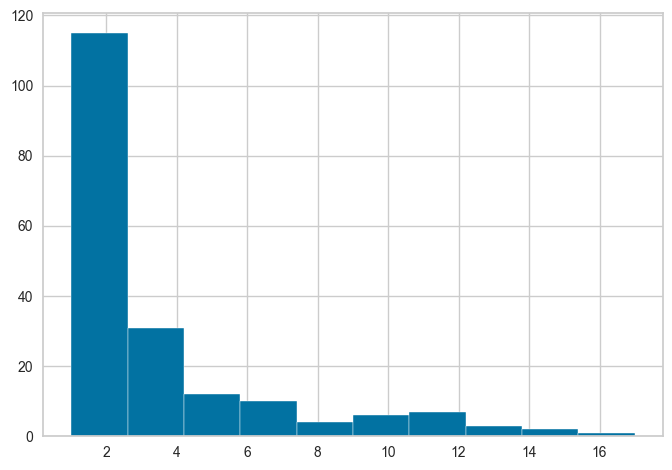

In [85]:
type1['albumCount'].hist()

In [86]:
type2 = endsAsStartNotAs.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()
type2['albumCount'] = endsAsStartNotAs.groupby('id_band').size().values

<AxesSubplot: >

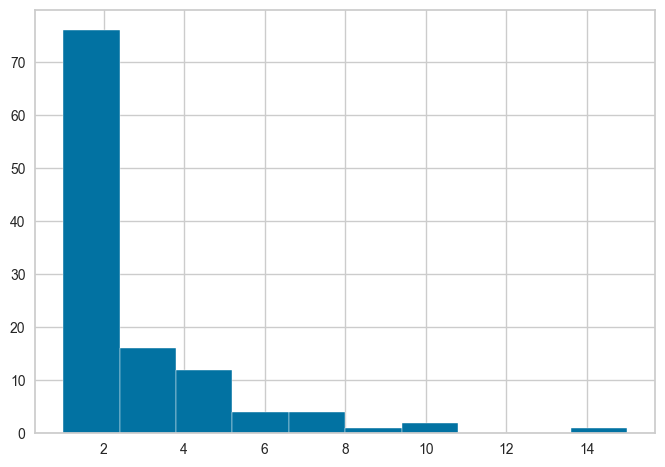

In [87]:
type2['albumCount'].hist()

In [88]:
type3 = alwaysDeath.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()
type3['albumCount'] = alwaysDeath.groupby('id_band').size().values

<AxesSubplot: >

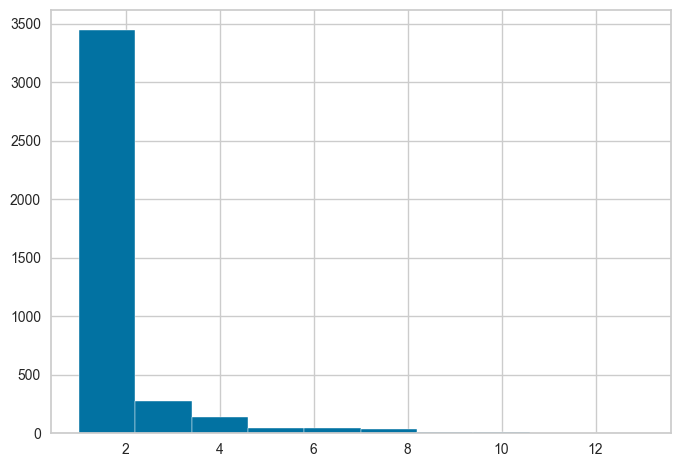

In [89]:
type3['albumCount'].hist()

In [90]:
type1['type']=0
type2['type']=1
type3['type']=2

In [91]:
typeConcat=pd.concat([type1,type2,type3],ignore_index=True)

In [92]:
typeConcat

,id_band,score,country,year,formed_in,albumCount,type
0,11143,0.500000,Australia,2009,2006.0,1,0
1,14768,0.770000,United States,2012,2000.0,1,0
2,16693,0.860000,France,2005,2000.0,2,0
3,16950,0.783333,Germany,2013,2009.0,1,0
4,20572,0.550000,Germany,2010,1996.0,3,0
...,...,...,...,...,...,...,...
4318,37086,0.804167,Russia,2007,2004.0,2,2
4319,37124,0.000000,Romania,2006,1991.0,1,2
4320,37574,0.760000,Finland,2014,2004.0,1,2
4321,37591,0.733750,Switzerland,2003,1998.0,4,2


# Diagrama de dispersión en relación al año de lanzamiento de los discos más exitosos o con mejor score y el puntuaje (score) recibido. No se observan clusters o agrupamiento de los datos.

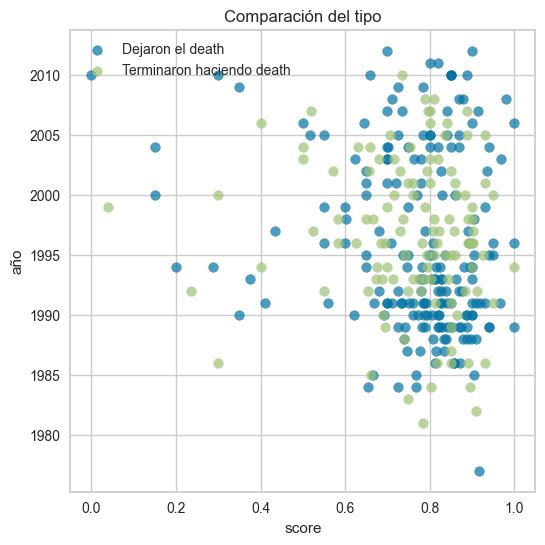

In [93]:
fig,ax=plt.subplots(figsize=(6,6))
ax.scatter(typeConcat[typeConcat['type']==0]['score'], typeConcat[typeConcat['type']==0]['formed_in'], alpha=0.7)
ax.scatter(typeConcat[typeConcat['type']==1]['score'], typeConcat[typeConcat['type']==1]['formed_in'], alpha=0.7)
#ax.scatter(typeConcat[typeConcat['type']==2]['score'], typeConcat[typeConcat['type']==2]['formed_in'], alpha=0.7)
ax.set_title('Comparación del tipo')
ax.set_xlabel('score')
ax.set_ylabel('año')
ax.legend(['Dejaron el death', 'Terminaron haciendo death'], loc='upper left')

# Diagrama de dispersión en relación al año de formación de la banda el puntuaje medio (score) recibido y el conteo de discos lanzadps. No se observan clusters o agrupamiento de los datos.

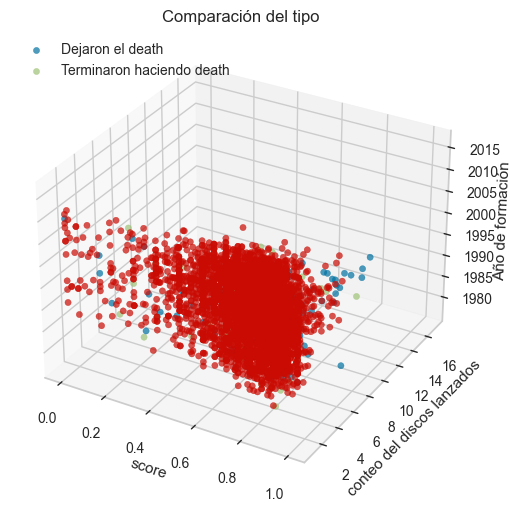

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(typeConcat[typeConcat['type']==0]['score'], typeConcat[typeConcat['type']==0]['albumCount'], typeConcat[typeConcat['type']==0]['formed_in'], alpha=0.7)
ax.scatter(typeConcat[typeConcat['type']==1]['score'], typeConcat[typeConcat['type']==1]['albumCount'], typeConcat[typeConcat['type']==1]['formed_in'], alpha=0.7)
ax.scatter(typeConcat[typeConcat['type']==2]['score'], typeConcat[typeConcat['type']==2]['albumCount'], typeConcat[typeConcat['type']==2]['formed_in'], alpha=0.7)

ax.set_title('Comparación del tipo')
ax.set_xlabel('score')
ax.set_ylabel('conteo del discos lanzados')
ax.set_zlabel('Año de formación')
ax.legend(['Dejaron el death', 'Terminaron haciendo death'], loc='upper left')

plt.show()


In [95]:
typeConcat.dropna(axis=0,how='any',inplace=True)

In [96]:
clf=KNeighborsClassifier(n_neighbors=10)
Xt=typeConcat[['albumCount','score']]
yt=typeConcat['type']
clf.fit(Xt,yt)

KNeighborsClassifier(n_neighbors=10)

In [97]:
clf=KNeighborsClassifier(n_neighbors=10)
Xed=typeConcat[['formed_in','score']]
yed=typeConcat['type']
clf.fit(Xed,yed)

KNeighborsClassifier(n_neighbors=10)

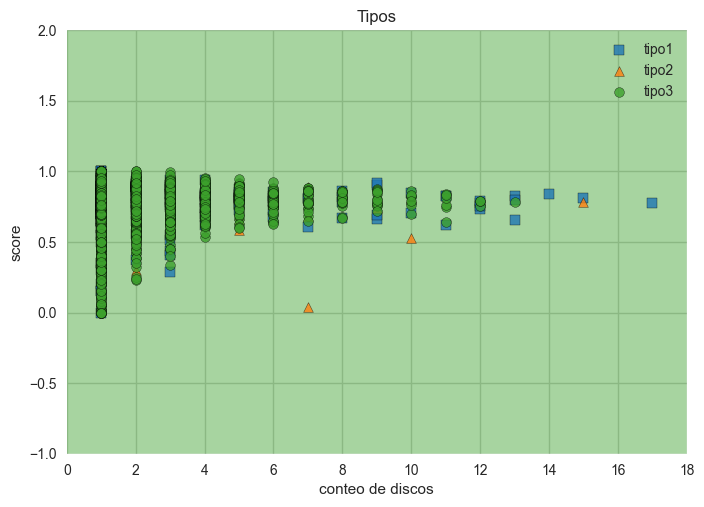

In [98]:
Xn=Xt.values
yn=yt.values

ax=plot_decision_regions(Xn, yn, clf=clf)# Añadir anotaciones

plt.xlabel('conteo de discos')
plt.ylabel('score')
plt.title('Tipos')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ['tipo1', 'tipo2', 'tipo3'],
           framealpha=0.3, scatterpoints=1)
plt.show()

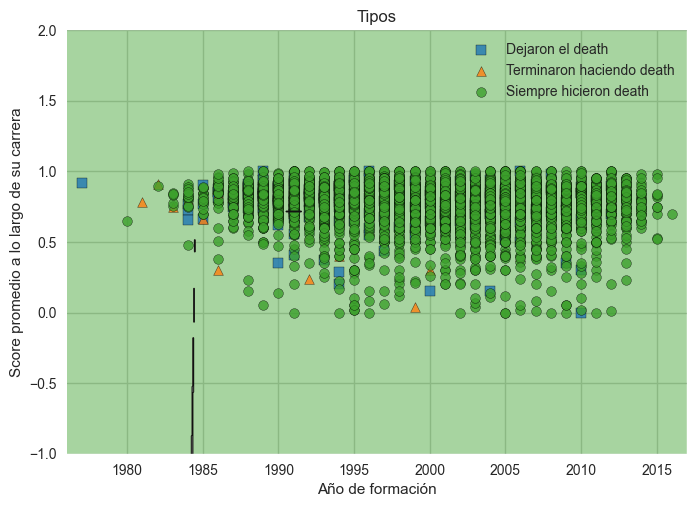

In [99]:
X2ed=Xed.values
y2ed=yed.values

ax=plot_decision_regions(X2ed, y2ed, clf=clf)# Añadir anotaciones

plt.xlabel('Año de formación')
plt.ylabel('Score promedio a lo largo de su carrera')
plt.title('Tipos')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ['Dejaron el death', 'Terminaron haciendo death', 'Siempre hicieron death'],
           framealpha=0.3, scatterpoints=1)
plt.show()

# Aunque en los tratamientos anteriores no se observaron agrupamientos claros de los datos, al entrar a considerar el conteo de discos lanzados y el puntaje por medio de arboles de decisión ya es posible observar las fronteras o curvas de decisión

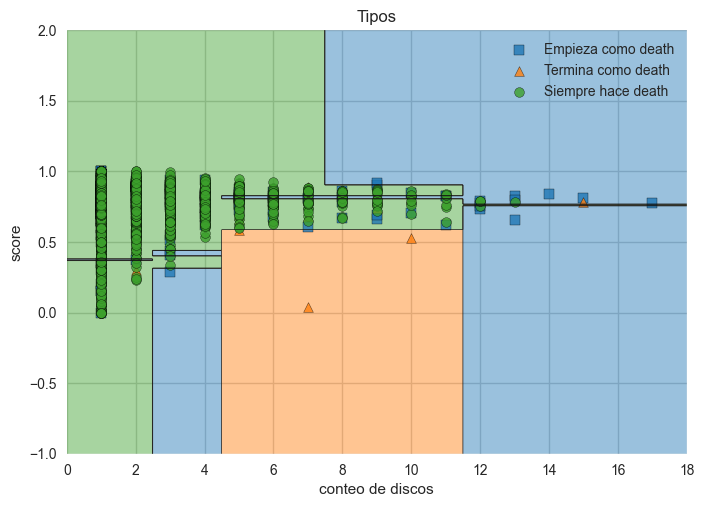

In [100]:
# Crear la instancia del modelo
clf = DecisionTreeClassifier(max_depth=6)

# Entrenar el modelo con los datos y la etiqueta
X=typeConcat[['albumCount','score']]
y=typeConcat['type']

# Entrenar el modelo con los datos y la etiqueta
clf.fit(X, y)

Xm= X.values
ym= y.values

# revisar https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#plot_decision_regions-visualize-the-decision-regions-of-a-classifier
ax=plot_decision_regions(Xm, ym, clf=clf)# Añadir anotaciones

plt.xlabel('conteo de discos')
plt.ylabel('score')
plt.title('Tipos')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ['Empieza como death', 'Termina como death', 'Siempre hace death'],
           framealpha=0.3, scatterpoints=1)
plt.show()

In [101]:
type_means = typeConcat[['formed_in', 'albumCount', 'score']]


In [102]:
type_means.dropna(axis=0,how='any',inplace=True)

# Implementación de clustering por k-means

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
""""
mediante la libreria sklearn se construye un pipeline, donde los datos deben ser estandarizados
ya que al tener las variables de entrada diferente naturaleza, puede generar ruido en la segmentación.
"""

modelo= Pipeline([('scaler', StandardScaler()),

                  ('model',KMeans(n_clusters=5, max_iter=1000, init='random', random_state=42))
])

modelo.fit_predict(type_means)
preds = modelo.fit_predict(type_means)

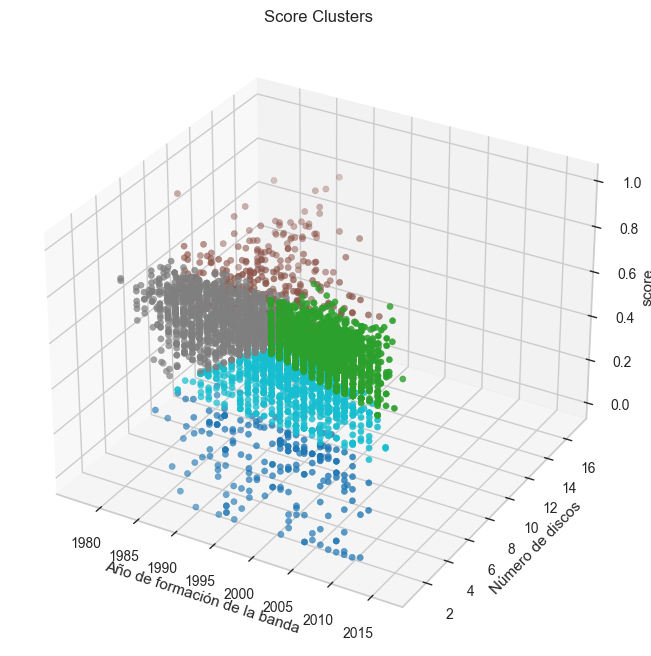

In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection="3d")
ax.scatter3D(type_means["formed_in"], type_means["albumCount"], type_means["score"], c=preds, cmap="tab10")
plt.title("Score Clusters")
ax.set_xlabel("Año de formación de la banda")
ax.set_ylabel("Número de discos")
ax.set_zlabel("score")
plt.show()

In [105]:
preds=pd.DataFrame(preds)
predsConcat=pd.concat([type_means,preds],axis=1)
predsConcat.rename(columns={0:'cluster'},inplace=True)
predsConcat.groupby(["cluster"])["formed_in","albumCount","score"].describe()

formed_in                                                          \
            count         mean       std     min      25%     50%     75%   
cluster                                                                     
0.0         199.0  2000.768844  7.220680  1982.0  1995.50  2001.0  2006.0   
1.0        1494.0  2001.307898  6.979271  1982.0  1996.25  2002.0  2007.0   
2.0         329.0  1999.155015  7.439818  1977.0  1993.00  1999.0  2005.0   
3.0        1244.0  2000.229100  7.265990  1983.0  1995.00  2001.0  2006.0   
4.0         891.0  2000.868687  7.017765  1980.0  1996.00  2002.0  2006.0   

                albumCount            ...              score            \
            max      count      mean  ...  75%   max   count      mean   
cluster                               ...                                
0.0      2014.0      199.0  1.693467  ...  2.0   9.0   199.0  0.737824   
1.0      2015.0     1494.0  1.605087  ...  2.0  12.0  1494.0  0.764711   
2.0      2013.0      329.0  2.908815  ...  4.0  17.0   329.0  0.767536   
3.0      2016.0     1244.0  1.683280  ...  2.0  13.0  1244.0  0.765928   
4.0      2015.0      891.0  1.750842  ...  2.0  15.0   891.0  0.759190   

                                                                
              std       min       25%       50%       75%  max  
cluster                                                         
0.0      0.189175  0.000000  0.680000  0.785312  0.870000  1.0  
1.0      0.154176  0.000000  0.702708  0.800000  0.860000  1.0  
2.0      0.148346  0.038571  0.700000  0.793333  0.863021  1.0  
3.0      0.150718  0.000000  0.700000  0.800000  0.861542  1.0  
4.0      0.146792  0.000000  0.700000  0.790000  0.850000  1.0  

[5 rows x 24 columns]

# Nuevos calculos de probabilidad para clustering y componentes principales

En el desarrollo del análisis, he construido dos nuevos dataframes a través de funciones de agregación. En estos, segmenté los datos en tres categorías distintas basadas en el tipo de transición de género que las bandas experimentaron. Los campos incorporados incluyen el puntaje promedio de los álbumes, el país de procedencia, el año modal en que se lanzaron los álbumes y el año de formación de la banda. Este diseño estructurado me facilita la aplicación tanto de algoritmos de clasificación supervisados como no supervisados, con el propósito de obtener insights más detallados y profundos sobre las tendencias y patrones subyacentes en los datos.

In [106]:
df1_avg

,id_band,score,name,country,genre,album_title,year
0,11143,0.500000,Cuntscrape,Australia,Death Metal | Goregrind,Papsmear Campaign,2009
1,14768,0.770000,Psychiatric Regurgitation,United States,Death Metal | Goregrind,Stabbed in the Eyes with a Crack Pipe,2012
2,16693,0.860000,Four Question Marks,France,Death Metal | Groove,Aleph,2005
3,16950,0.783333,Acranius,Germany,Brutal Death Metal | Hardcore,When Mutation Becomes Homicidal,2013
4,20572,0.550000,Emergency Gate,Germany,Melodic Death Metal | core,Infected,2010
...,...,...,...,...,...,...,...
186,37709,0.410000,Pyogenesis,Germany,Death Metal/Doom (early)| Gothic | Alternative Rock/Pop Punk (later),A Century in the Curse of Time,1994
187,37713,0.622500,The Showdown,United States,Melodic Thrash/Death Metal /core (early)| Southern/Heavy (later),A Chorus of Obliteration,2004
188,37714,0.812976,Theatre of Tragedy,Norway,Gothic/Doom/Death Metal (early)| Industrial/Electronica| Gothic /Rock (later),Assembly,1995
189,37719,0.880000,Gladiator,Slovakia,Death Metal/Thrash (1988-93)| Grunge/Hard Rock (1994-present),Designation,1992


In [107]:
tipo1=endsNotAsStartAs.copy()
tipo2=endsAsStartNotAs.copy()
tipo3=alwaysDeath.copy()

class1 = tipo1.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class2 = tipo2.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class3 = tipo3.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class1['prob'] = class1['country'].apply(lambda x: probability1ed(x))
class2['prob'] = class2['country'].apply(lambda x: probability2ed(x))
class3['prob'] = class3['country'].apply(lambda x: probability3ed(x))
class1['albumCount'] = endsNotAsStartAs.groupby('id_band').size().values
class2['albumCount'] = endsAsStartNotAs.groupby('id_band').size().values
class3['albumCount'] = alwaysDeath.groupby('id_band').size().values
class1['type']=1
class2['type']=2
class3['type']=3
classConcat=pd.concat([class1,class2,class3],ignore_index=True)
classMeans=classConcat[['score','albumCount','prob']]




In [108]:
tipo1R=endsNotAsStartAs.copy()
tipo2R=endsAsStartNotAs.copy()
tipo3R=alwaysDeath.copy()

class1R = tipo1R.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class2R = tipo2R.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class3R = tipo3R.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
    'formed_in':lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
}).reset_index()

class1R['prob'] = class1['country'].apply(lambda x: probability1R(x))
class2R['prob'] = class2['country'].apply(lambda x: probability2R(x))
class3R['prob'] = class3['country'].apply(lambda x: probability3R(x))
class1R['albumCount'] = endsNotAsStartAs.groupby('id_band').size().values
class2R['albumCount'] = endsAsStartNotAs.groupby('id_band').size().values
class3R['albumCount'] = alwaysDeath.groupby('id_band').size().values
class1R['type']=1
class2R['type']=2
class3R['type']=3
classConcatR=pd.concat([class1R,class2R,class3R],ignore_index=True)
classMeansR=classConcatR[['score','albumCount','prob']]
classConcatR=classConcatR.dropna(subset=['prob'])
classMeansR=classMeansR.dropna(subset=['prob'])

In [109]:
classConcatR

,id_band,score,country,year,formed_in,prob,albumCount,type
0,11143,0.500000,Australia,2009,2006.0,0.571429,1,1
1,14768,0.770000,United States,2012,2000.0,0.628571,1,1
2,16693,0.860000,France,2005,2000.0,0.800000,2,1
3,16950,0.783333,Germany,2013,2009.0,0.812500,1,1
4,20572,0.550000,Germany,2010,1996.0,0.812500,3,1
...,...,...,...,...,...,...,...,...
4317,37083,0.825000,China,2008,2000.0,0.500000,1,3
4318,37086,0.804167,Russia,2007,2004.0,0.600000,2,3
4320,37574,0.760000,Finland,2014,2004.0,0.691099,1,3
4321,37591,0.733750,Switzerland,2003,1998.0,0.588235,4,3


In [110]:
len(classMeans)

4323

In [111]:
modeloClassR= Pipeline([('scaler', StandardScaler()),

                  ('model',KMeans(n_clusters=5, max_iter=1000, init='random', random_state=42))
])

modeloClassR.fit_predict(classMeansR)
predsclassR = modeloClassR.fit_predict(classMeansR)

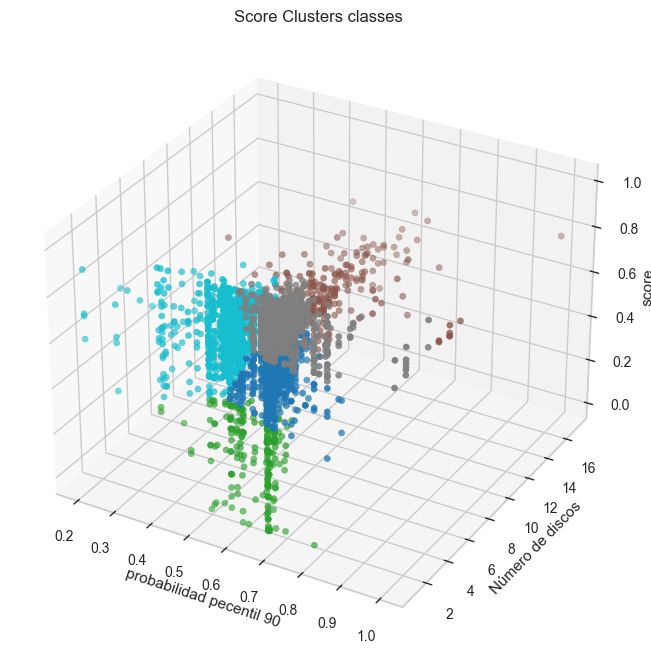

In [112]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection="3d")
ax.scatter3D(classMeansR["prob"], classMeansR["albumCount"], classMeansR["score"], c=predsclassR, cmap="tab10")
plt.title("Score Clusters classes")
ax.set_xlabel("probabilidad pecentil 90")
ax.set_ylabel("Número de discos")
ax.set_zlabel("score")
plt.show()

In [113]:
modeloClass= Pipeline([('scaler', StandardScaler()),

                  ('model',KMeans(n_clusters=5, max_iter=1000, init='random', random_state=42))
])

modeloClass.fit_predict(classMeans)
predsclass = modeloClass.fit_predict(classMeans)

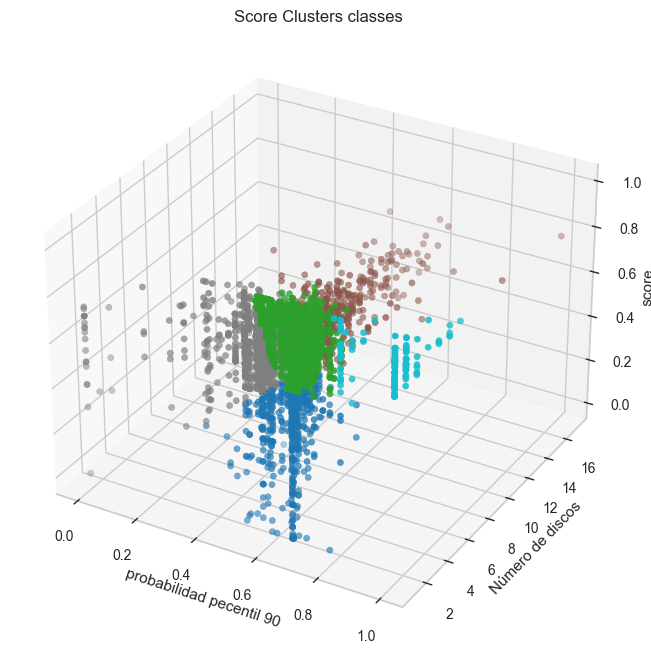

In [114]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection="3d")
ax.scatter3D(classMeans["prob"], classMeans["albumCount"], classMeans["score"], c=predsclass, cmap="tab10")
plt.title("Score Clusters classes")
ax.set_xlabel("probabilidad pecentil 90")
ax.set_ylabel("Número de discos")
ax.set_zlabel("score")
plt.show()

In [115]:
classMeans.columns

Index(['score', 'albumCount', 'prob'], dtype='object')

In [116]:
pcaModel=PCA(n_components=3)
pcaModel.fit(classMeans)

PCA(n_components=3)

In [117]:
pcaModelR=PCA(n_components=3)
pcaModelR.fit(classMeansR)

PCA(n_components=3)

In [118]:
compListR=['c1','c2','c3']
compsR=pd.DataFrame(data=pcaModelR.components_,columns=classMeansR.columns,index=compListR)
compsR

,score,albumCount,prob
c1,0.006689,0.999974,0.002615
c2,-0.998252,0.006831,-0.058707
c3,0.058723,0.002218,-0.998272


In [119]:
compList=['c1','c2','c3']
comps=pd.DataFrame(data=pcaModel.components_,columns=classMeans.columns,index=compList)
comps

,score,albumCount,prob
c1,0.006415,0.999976,0.002740
c2,-0.985554,0.006786,-0.169223
c3,0.169237,0.001615,-0.985574


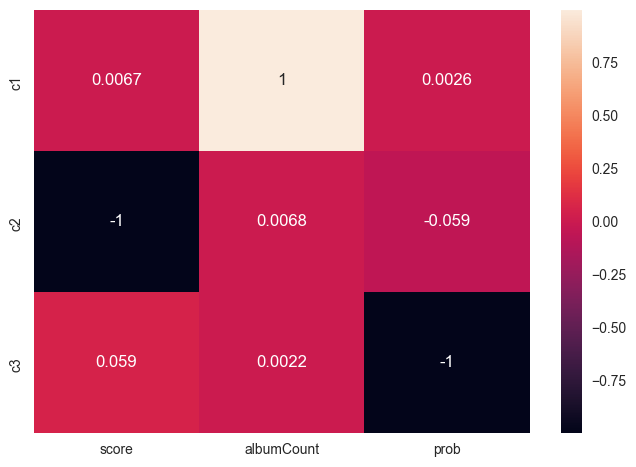

In [120]:
axcompR=sns.heatmap(compsR,annot=True)

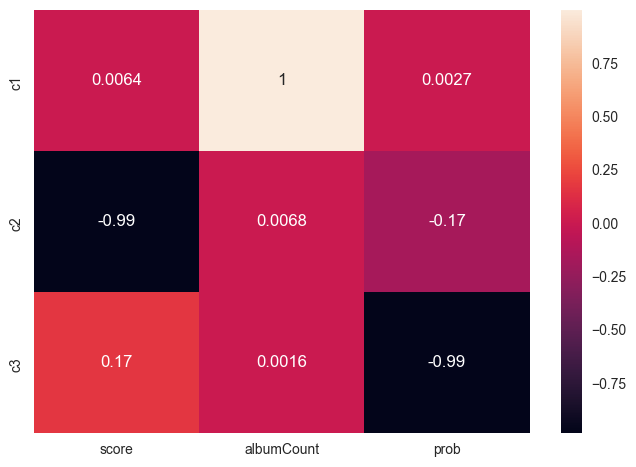

In [121]:
axcomp=sns.heatmap(comps,annot=True)

In [122]:
print(pcaModel.explained_variance_ratio_.round(2))

[0.99 0.01 0.  ]


In [123]:
print(pcaModelR.explained_variance_ratio_.round(2))

[0.99 0.01 0.  ]


In [124]:
proyR=pd.DataFrame(pcaModelR.transform(classMeansR),index=classMeansR.index,columns=compListR)
proyR.drop(columns=['c2','c3'],inplace=True)
proyR['type']=classConcatR['type']
proyR

,c1,type
0,-0.761527,1
1,-0.759572,1
2,0.241453,1
3,-0.759002,1
4,1.239386,1
...,...,...
4317,-0.759540,3
4318,0.240556,3
4320,-0.759475,3
4321,2.240003,3


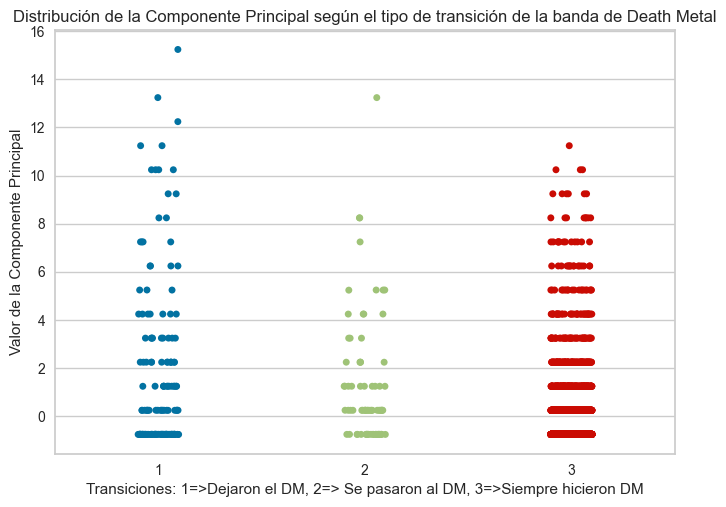

In [125]:
sns.stripplot(x="type", y="c1", data=proyR, jitter=True)
plt.title("Distribución de la Componente Principal según el tipo de transición de la banda de Death Metal")
plt.xlabel("Transiciones: 1=>Dejaron el DM, 2=> Se pasaron al DM, 3=>Siempre hicieron DM")
plt.ylabel("Valor de la Componente Principal")
plt.savefig("PCADM.png")
plt.show()

In [126]:
proy=pd.DataFrame(pcaModel.transform(classMeans),index=classMeans.index,columns=compList)
proy.drop(columns=['c2','c3'],inplace=True)
proy['type']=classConcat['type']
proy

,c1,type
0,-0.756695,1
1,-0.754807,1
2,0.246216,1
3,-0.754217,1
4,1.244238,1
...,...,...
4318,0.245310,3
4319,-0.761469,3
4320,-0.754699,3
4321,2.244777,3


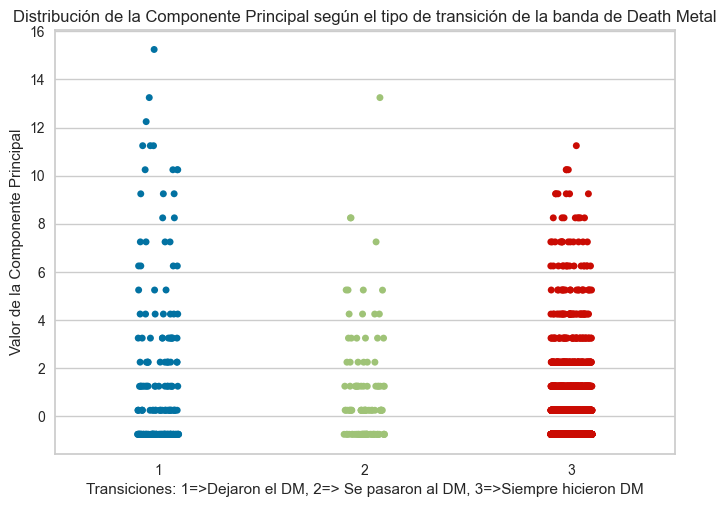

In [127]:
sns.stripplot(x="type", y="c1", data=proy, jitter=True)
plt.title("Distribución de la Componente Principal según el tipo de transición de la banda de Death Metal")
plt.xlabel("Transiciones: 1=>Dejaron el DM, 2=> Se pasaron al DM, 3=>Siempre hicieron DM")
plt.ylabel("Valor de la Componente Principal")
plt.savefig("PCADM.png")
plt.show()


# Algunos cálculos de la probabilidad de obtener scores en el percentil 90 filtrando por paises (series de tiempo)

In [128]:
df_probability1['year'] = pd.to_numeric(df_probability1['year'], errors='coerce')
df_probability2['year'] = pd.to_numeric(df_probability2['year'], errors='coerce')
df_probability3['year'] = pd.to_numeric(df_probability3['year'], errors='coerce')


In [129]:
df_probability1['probability_smooth'] = df_probability1['probability'].rolling(window=5).mean()
df_probability2['probability_smooth'] = df_probability2['probability'].rolling(window=5).mean()
df_probability3['probability_smooth'] = df_probability3['probability'].rolling(window=5).mean()

In [130]:
@interact
def plotProb(country=list(df_probability1.country.unique())):
    filtered_prob1 = df_probability1[df_probability1.country == country]
    filtered_prob2 = df_probability2[df_probability2.country == country]
    filtered_prob3 = df_probability3[df_probability3.country == country]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,7)) # Define una figura con tres subgráficos dispuestos horizontalmente

    sns.lineplot(data=filtered_prob1, x='year',y='probability',label='Switch gender',color='blue', ax=axes[0]) # Plot en el primer eje
    axes[0].set_title('Switch gender')  # Define el título del primer eje

    sns.lineplot(data=filtered_prob2, x='year',y='probability',label='Switch to death metal',color='magenta', ax=axes[1]) # Plot en el segundo eje
    axes[1].set_title('Switch to death metal')  # Define el título del segundo eje

    sns.lineplot(data=filtered_prob3, x='year',y='probability',label='death metal',color='orange', ax=axes[2]) # Plot en el tercer eje
    axes[2].set_title('death metal')  # Define el título del tercer eje

    for ax in axes:  # Define los títulos de los ejes x e y para cada subgráfico
        ax.set_xlabel('Year')  
        ax.set_ylabel('Probability')

    plt.tight_layout()  # Asegura un buen espaciamiento entre los subgráficos
    plt.show()


interactive(children=(Dropdown(description='country', options=('Australia', 'United States', 'France', 'German…

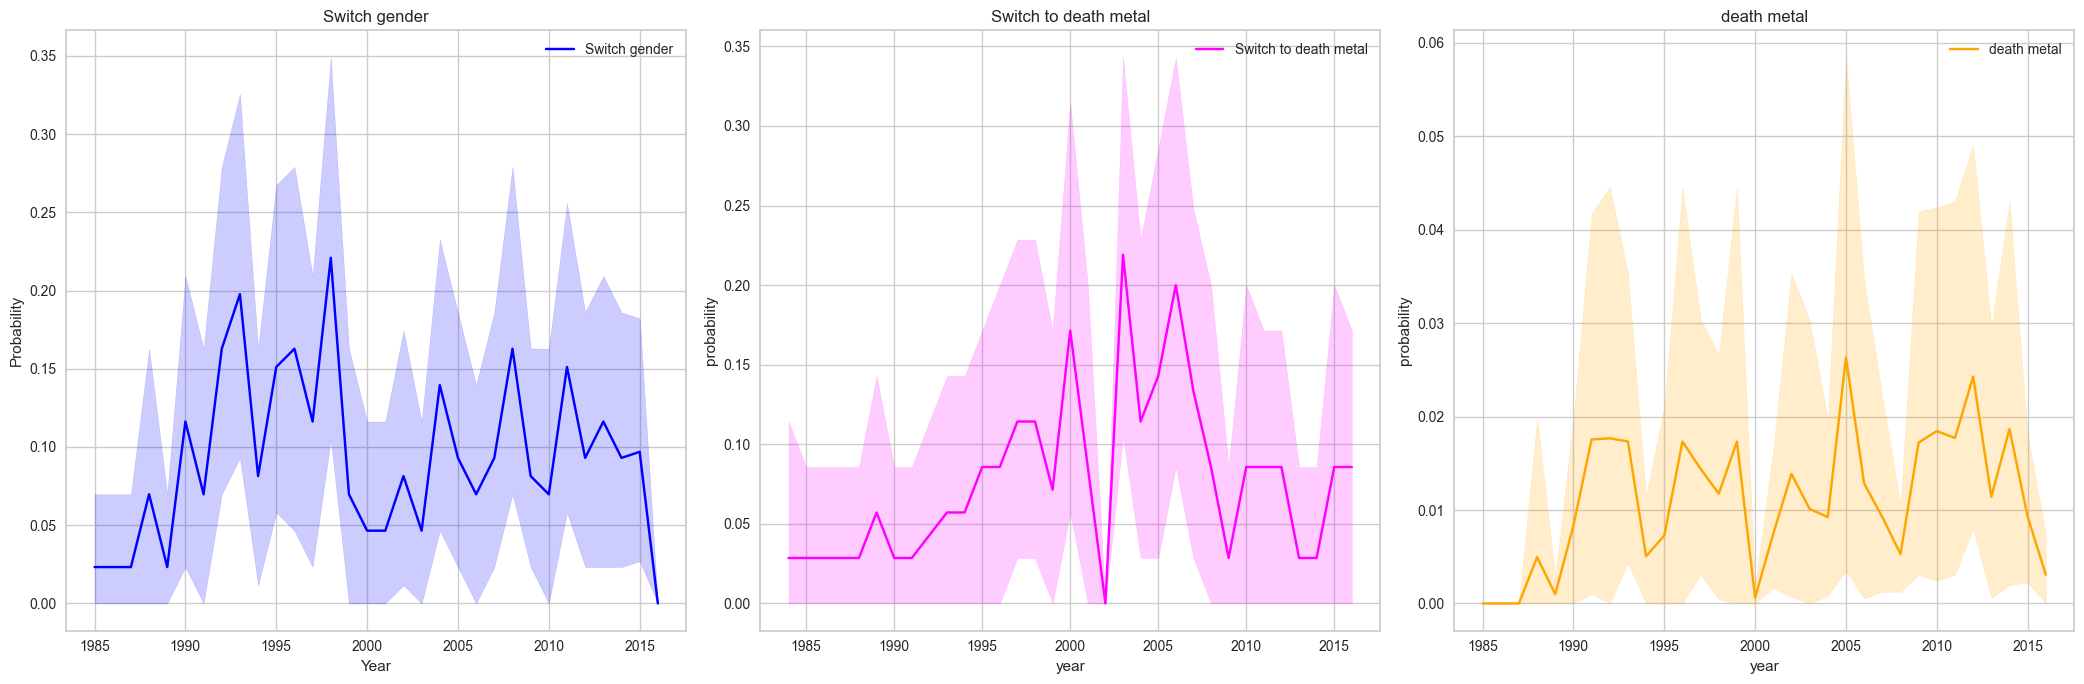

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [131]:
 fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,7)) # Define una figura con tres subgráficos dispuestos horizontalmente

sns.lineplot(data=df_probability1, x='year',y='probability',label='Switch gender',color='blue', ax=axes[0]) # Plot en el primer eje
axes[0].set_title('Switch gender')  # Define el título del primer eje

sns.lineplot(data=df_probability2, x='year',y='probability',label='Switch to death metal',color='magenta', ax=axes[1]) # Plot en el segundo eje
axes[1].set_title('Switch to death metal')  # Define el título del segundo eje

sns.lineplot(data=df_probability3, x='year',y='probability',label='death metal',color='orange', ax=axes[2]) # Plot en el tercer eje
axes[2].set_title('death metal')  # Define el título del tercer eje

for ax in axes:  # Define los títulos de los ejes x e y para cada subgráfico
    ax.set_xlabel('Year')  
    ax.set_ylabel('Probability')

    plt.tight_layout()  # Asegura un buen espaciamiento entre los subgráficos
    plt.show()

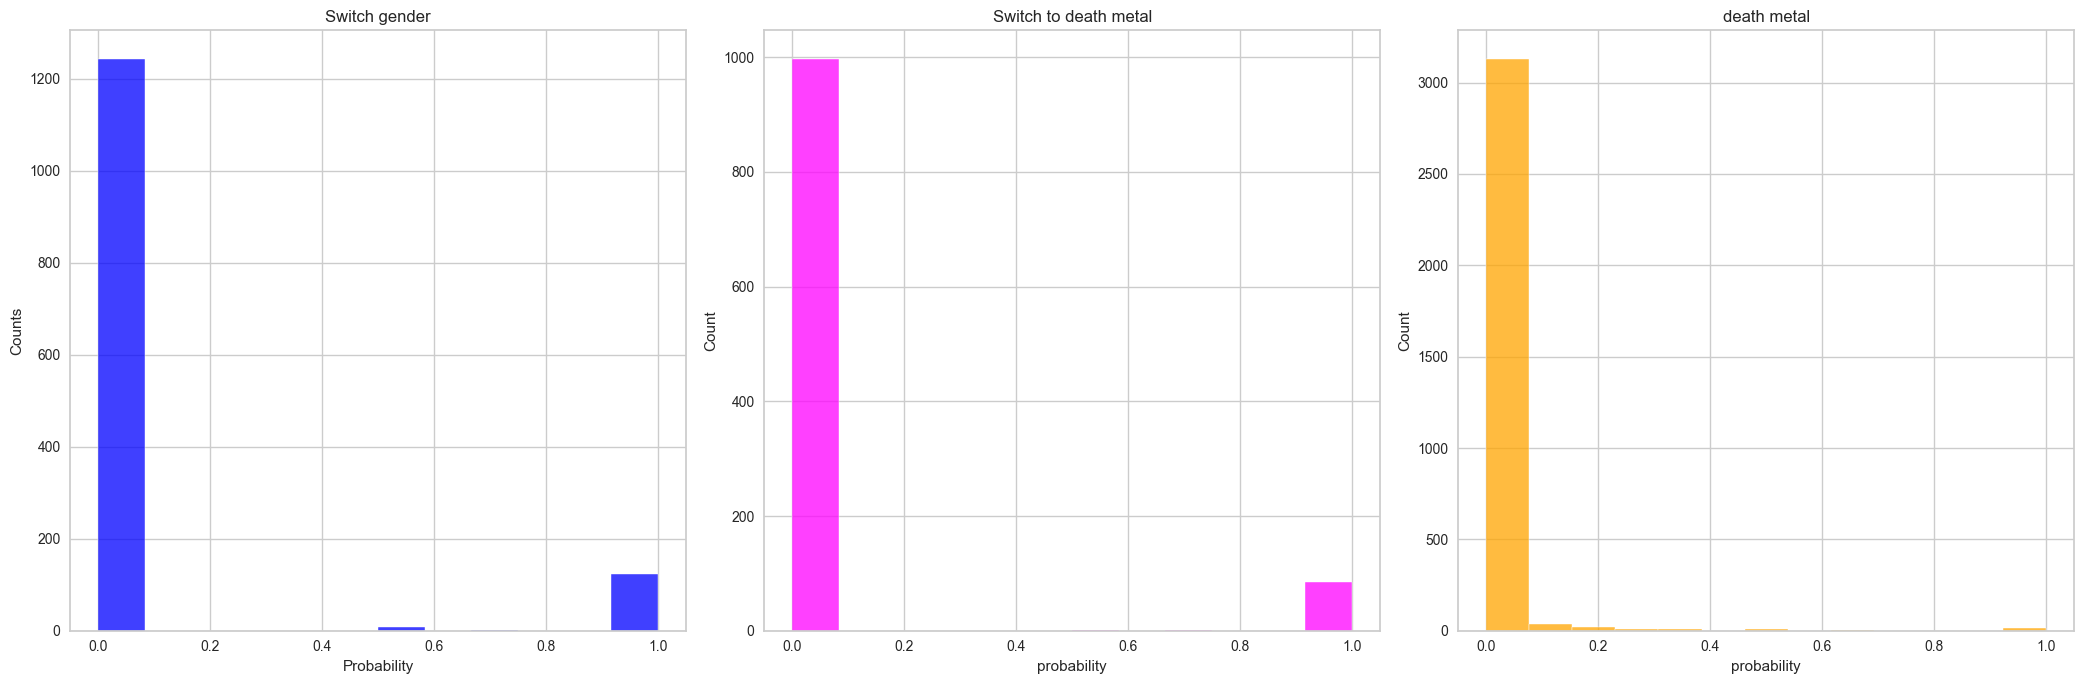

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [132]:
 fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,7)) # Define una figura con tres subgráficos dispuestos horizontalmente

sns.histplot(data=df_probability1, x='probability',label='Switch gender',color='blue', ax=axes[0]) # Plot en el primer eje
axes[0].set_title('Switch gender')  # Define el título del primer eje

sns.histplot(data=df_probability2, x='probability',label='Switch to death metal',color='magenta', ax=axes[1]) # Plot en el segundo eje
axes[1].set_title('Switch to death metal')  # Define el título del segundo eje

sns.histplot(data=df_probability3, x='probability',label='death metal',color='orange', ax=axes[2]) # Plot en el tercer eje
axes[2].set_title('death metal')  # Define el título del tercer eje

for ax in axes:  # Define los títulos de los ejes x e y para cada subgráfico
    ax.set_xlabel('Probability')  
    ax.set_ylabel('Counts')

    plt.tight_layout()  # Asegura un buen espaciamiento entre los subgráficos
    plt.show()

Se puede observar mucha fluctuación y ruido en los datos, observandosé aparentes grandes varianzas. Tentativamente se podría especular que hay un crecimiento aparentemente lineal en el score de las bandas que han permanecido haciendo death metal (comportamiento global), no obstrante es menestre calcular todos los indicadores, entre esos el coeficiente de correlación para determinar la naturaleza de las tendencias observadas en los datos

# Determinación y limpieza de datos atípicos

Detección y Manejo de Datos Atípicos

En una fase crucial del análisis, dediqué un segmento del estudio a la identificación y gestión de datos atípicos dentro del dataset. Reconociendo la influencia significativa que los valores extremos pueden tener en los resultados y las interpretaciones, desarrollé funciones específicas para:

Conteo: Estas funciones ofrecen una visión rápida y cuantitativa de la presencia de datos atípicos en las distintas variables del conjunto de datos.

Detección: A través de métodos estadísticos, estas funciones señalan con precisión aquellos puntos que se desvían de la norma general de la distribución.

Filtrado: Una vez identificados, es vital decidir si se deben mantener, ajustar o eliminar estos valores. Las funciones de filtrado me permiten tomar decisiones informadas, garantizando que el dataset sea lo más representativo y libre de distorsiones posibles.

Este enfoque estructurado y metódico asegura que cualquier análisis subsiguiente se realice sobre datos limpios y precisos, mejorando la confiabilidad y validez de los resultados obtenidos.

In [133]:
valor_max = df1_avg["score"].quantile(0.75) + 1.5*(df1_avg["score"].quantile(0.75)-df1_avg["score"].quantile(0.25))
valor_max

1.09125

In [134]:
outliers = df1_avg["score"][df1_avg["score"]>valor_max]
#len(outliers) versión alternativa para el total de la serie
outliers.count()

0

# Funciones para determinar datos atipicos por encima con z por encima de 3 e inferiores a -3

In [135]:
@interact
def filter_outliers(outliers=list(df3_avg.country.unique())):
    filtered_outliers=df3_avg[df3_avg['country']==outliers]
    max_value=filtered_outliers["score"].quantile(0.75) + 1.5*(filtered_outliers["score"].quantile(0.75)-filtered_outliers["score"].quantile(0.25))
    outliers = filtered_outliers["score"][filtered_outliers["score"]>max_value]
    count=outliers.count()
    return count

interactive(children=(Dropdown(description='outliers', options=('Argentina', 'United States', 'Finland', 'Braz…

In [136]:
@interact
def filter_outliers(outliers=list(df3_avg.country.unique())):
    filtered_outliers=df3_avg[df3_avg['country']==outliers]
    min_value=filtered_outliers["score"].quantile(0.25) - 1.5*(filtered_outliers["score"].quantile(0.75)-filtered_outliers["score"].quantile(0.25))
    outliers = filtered_outliers["score"][filtered_outliers["score"]<min_value]
    count=outliers.count()
    return count

interactive(children=(Dropdown(description='outliers', options=('Argentina', 'United States', 'Finland', 'Braz…

In [137]:
df1_zScore=df1_avg.copy()
df2_zScore=df2_avg.copy()
df3_zScore=df3_avg.copy()

In [138]:
@interact
def zScore3(z3=list(df3_zScore.country.unique())):
    filteredZscore3=df3_zScore[df3_zScore['country']==z3]
    filteredZscore3['score_z']=(filteredZscore3['score']-filteredZscore3['score'].mean())/filteredZscore3['score'].std()
    filteredZscore3['score_outliers']=0
    filteredZscore3.loc[(filteredZscore3['score_z']>3)|(filteredZscore3['score_z']<-3),'score_outliers']=1
    finalFiltered3=filteredZscore3[['score','score_z','score_outliers']]
    counts=finalFiltered3['score_outliers'].value_counts()
    outlier=finalFiltered3["score"][finalFiltered3["score_outliers"]==1]
    return outlier

interactive(children=(Dropdown(description='z3', options=('Argentina', 'United States', 'Finland', 'Brazil', '…

In [139]:
count_zeroes1 = (df_probability1['probability'] == 0).sum()
count_zeroes2 = (df_probability2['probability'] == 0).sum()
count_zeroes3 = (df_probability3['probability'] == 0).sum()
print(f"el número de ceros en df1 es {count_zeroes1} siendo la longitud de este {len(df_probability1)}, en df2 es {count_zeroes2} siendo la longitud de este {len(df_probability2)} y en df3 es {count_zeroes3}, siendo la longitud de este {len(df_probability3)}")


el número de ceros en df1 es 1243 siendo la longitud de este 1376, en df2 es 997 siendo la longitud de este 1085 y en df3 es 3103, siendo la longitud de este 3232


In [140]:
def outliersFilter(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    df[col] = df[col].where(~filtro, np.nan)
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)
    return df



In [141]:
zdf=[df1_zScore,df2_zScore,df3_zScore]
for df in zdf:
    outliersFilter(df,'score')

# En esta sección voy a quitar outliers de mis dataframes para cada tipo de transción e imputar los datos que sean outliers para pasar una regresión lineal multivariada

In [142]:
t1_zScore=endsNotAsStartAs.copy()
t2_zScore=endsAsStartNotAs.copy()
t3_zScore=alwaysDeath.copy()

In [143]:
lrDF=[t1_zScore,t2_zScore,t3_zScore]
for df in lrDF:
    outliersFilter(df,'score')

In [144]:
def scoreCount1LR(country):
    scoreLen1LR=len(lrDF[0][lrDF[0]['country']==country])
    return scoreLen1LR
def scoreCount2LR(country):
    scoreLen2LR=len(lrDF[1][lrDF[1]['country']==country])
    return scoreLen2LR
def scoreCount3LR(country):
    scoreLen3LR=len(lrDF[2][lrDF[2]['country']==country])
    return scoreLen3LR

lenData1LR=[]
for country in countries1:
    lenData1LR.append({
    'country':country,
    'count': scoreCount1LR(country)    
    })
df_len1LR=pd.DataFrame(lenData1LR)    

lenData2LR=[]
for country in countries1:
    lenData2LR.append({
    'country':country,
    'count': scoreCount2LR(country)    
    })
df_len2LR=pd.DataFrame(lenData2LR)    

lenData3LR=[]
for country in countries1:
    lenData3LR.append({
    'country':country,
    'count': scoreCount3LR(country)    
    })
df_len3LR=pd.DataFrame(lenData3LR)    

In [145]:
def probability1LR(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount1LR(country)>=5:
        total_scores = len(lrDF[0][lrDF[0]['country'] == country])
        high_scores = len(lrDF[0][(lrDF[0]['country'] == country) &  (lrDF[0]['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan

def probability2LR(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount2LR(country)>=5:
        total_scores = len(lrDF[1][lrDF[1]['country'] == country])
        high_scores = len(lrDF[1][(lrDF[1]['country'] == country) & (lrDF[1]['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan

def probability3LR(country):
    total_scores = 0  
    high_scores = 0 
    if scoreCount3LR(country)>=5:
        total_scores = len(lrDF[2][lrDF[2]['country'] == country])
        high_scores = len(lrDF[2][(lrDF[2]['country'] == country) &  (lrDF[2]['score']>=0.75)])
    return high_scores / total_scores if total_scores > 0 else np.nan

In [146]:
tipo1LR=lrDF[0].copy()
tipo2LR=lrDF[1].copy()
tipo3LR=lrDF[2].copy()

class1LR = tipo1LR.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
}).reset_index()

class2LR = tipo2LR.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
}).reset_index()

class3LR = tipo3LR.groupby('id_band').agg({
    'score': 'mean',  # Calcular la media de 'score'
    'country': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'country'
    'year': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,  # Mantener el valor más común de 'year'
}).reset_index()

class1LR['prob'] = class1LR['country'].apply(lambda x: probability1LR(x))
class2LR['prob'] = class2LR['country'].apply(lambda x: probability2LR(x))
class3LR['prob'] = class3LR['country'].apply(lambda x: probability3LR(x))
class1LR['albumCount'] = lrDF[0].groupby('id_band').size().values
class2LR['albumCount'] = lrDF[1].groupby('id_band').size().values
class3LR['albumCount'] = lrDF[2].groupby('id_band').size().values
class1LR['type']=1
class2LR['type']=2
class3LR['type']=3
classConcatLR=pd.concat([class1LR,class2LR,class3LR],ignore_index=True)
classMeansLR=classConcatLR[['score','albumCount','prob']]
classConcatLR=classConcatLR.dropna(subset=['prob'])
classMeansLR=classMeansLR.dropna(subset=['prob'])

In [147]:
zdf[0].columns

Index(['id_band', 'score', 'name', 'country', 'genre', 'album_title', 'year'], dtype='object')

In [148]:
classConcatLR

,id_band,score,country,year,prob,albumCount,type
0,11143,0.500000,Australia,2009,0.666667,1,1
1,14768,0.770000,United States,2012,0.686275,1,1
2,16693,0.860000,France,2005,0.800000,2,1
3,16950,0.783333,Germany,2013,0.753623,1,1
4,20572,0.650000,Germany,2010,0.753623,3,1
...,...,...,...,...,...,...,...
4317,37083,0.825000,China,2008,0.700000,1,3
4318,37086,0.804167,Russia,2007,0.690141,2,3
4320,37574,0.760000,Finland,2014,0.705202,1,3
4321,37591,0.861250,Switzerland,2003,0.650000,4,3


In [149]:
classConcatLR['country'].unique()

array(['Australia', 'United States', 'France', 'Germany', 'Mexico',
       'Russia', 'Israel', 'Sweden', 'Finland', 'Italy', 'Norway',
       'Greece', 'United Kingdom', 'Poland', 'Croatia', 'Netherlands',
       'Switzerland', 'Brazil', 'Spain', 'Canada', 'Argentina', 'Belgium',
       'India', 'Slovakia', 'Japan', 'Chile', 'Colombia', 'International',
       'South Africa', 'Portugal', 'Hungary', 'Czech Republic', 'Latvia',
       'Uruguay', 'Denmark', 'Austria', 'Costa Rica', 'Malaysia',
       'New Zealand', 'Turkey', 'Philippines', 'Belarus', 'Indonesia',
       'Ukraine', 'Singapore', 'Thailand', 'Bulgaria', 'Peru', 'Ireland',
       'Puerto Rico', 'Taiwan', 'Iceland', 'Malta', 'Serbia',
       'Korea| South', 'Bosnia and Herzegovina', 'China', 'Andorra',
       'Jordan', 'Lebanon'], dtype=object)

In [150]:
# Crear una copia del DataFrame para mantener la columna original 'country'
classConcatEn = classConcatLR.copy()

# Inicializar y ajustar el codificador
encoder = TargetEncoder()
classConcatEn['country_encoded'] = encoder.fit_transform(classConcatEn['country'], classConcatEn['score'])


In [151]:
classConcatEn

,id_band,score,country,year,prob,albumCount,type,country_encoded
0,11143,0.500000,Australia,2009,0.666667,1,1,0.788580
1,14768,0.770000,United States,2012,0.686275,1,1,0.793552
2,16693,0.860000,France,2005,0.800000,2,1,0.772478
3,16950,0.783333,Germany,2013,0.753623,1,1,0.779656
4,20572,0.650000,Germany,2010,0.753623,3,1,0.779656
...,...,...,...,...,...,...,...,...
4317,37083,0.825000,China,2008,0.700000,1,3,0.775581
4318,37086,0.804167,Russia,2007,0.690141,2,3,0.772935
4320,37574,0.760000,Finland,2014,0.705202,1,3,0.787238
4321,37591,0.861250,Switzerland,2003,0.650000,4,3,0.777402


In [152]:
classConcatEn.loc[classConcatEn['country']=='Austria']

,id_band,score,country,year,prob,albumCount,type,country_encoded
448,1600,0.600000,Austria,2010,0.75,1,3,0.799022
469,1724,0.750000,Austria,2009,0.75,1,3,0.799022
581,2913,0.643333,Austria,1992,0.75,3,3,0.799022
873,5903,0.855000,Austria,1992,0.75,1,3,0.799022
1006,7318,0.884750,Austria,1990,0.75,2,3,0.799022
1232,9576,0.750000,Austria,2011,0.75,1,3,0.799022
1413,10916,0.800000,Austria,2004,0.75,1,3,0.799022
1455,11243,0.805000,Austria,1997,0.75,2,3,0.799022
1520,11710,0.800000,Austria,2013,0.75,1,3,0.799022
1787,13570,0.640000,Austria,2006,0.75,1,3,0.799022


In [153]:
encodedClassConcat=classConcatEn.groupby('country').agg({
'score':'mean',
'country_encoded': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
 'albumCount': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,   
}).reset_index()

In [154]:
# Tu función de agregación original para crear encodedClassConcat
encodedClassConcat3 = classConcatEn.groupby('country').agg({
    'score': 'mean',
    'albumCount': 'mean',
}).reset_index()

# Paso 1: Contar el número total de bandas por país
total_count = classConcatEn.groupby('country').size().reset_index(name='Total_Bands')

# Paso 2: Contar el número de bandas de type1 y type2 por país
type1_type2_count = classConcatEn[classConcatEn['type'].isin([1, 2])].groupby('country').size().reset_index(name='switched_bands_count')

# Paso 3: Fusionar los DataFrames
encodedClassConcat3 = pd.merge(encodedClassConcat3, total_count, on='country', how='left')
encodedClassConcat3 = pd.merge(encodedClassConcat3, type1_type2_count, on='country', how='left')

# Rellenar NaN con 0
encodedClassConcat3['switched_bands_count'].fillna(0, inplace=True)

# Calcular la proporción y agregarla como una nueva columna
encodedClassConcat3['switched_bands_percentage'] = round((encodedClassConcat3['switched_bands_count'] / encodedClassConcat3['Total_Bands'])*100,2)





In [155]:
encodedClassConcat3[['score','albumCount','switched_bands_percentage']]

,score,albumCount,switched_bands_percentage
0,0.771824,2.500000,0.00
1,0.779565,1.260870,0.00
2,0.788580,1.547445,5.11
3,0.801807,1.764706,0.00
4,0.838333,1.714286,0.00
5,0.803641,1.586957,0.00
6,0.818000,1.200000,0.00
7,0.770483,1.900000,3.33
8,0.808889,2.500000,0.00
9,0.799242,1.510204,1.53


In [156]:
encodedClassConcat3['score'].min()

0.7074652777777778

In [157]:
xCon1 = encodedClassConcat3[['albumCount', 'switched_bands_percentage']].values  # Variables independientes
yCon1 = encodedClassConcat3['score'].values 

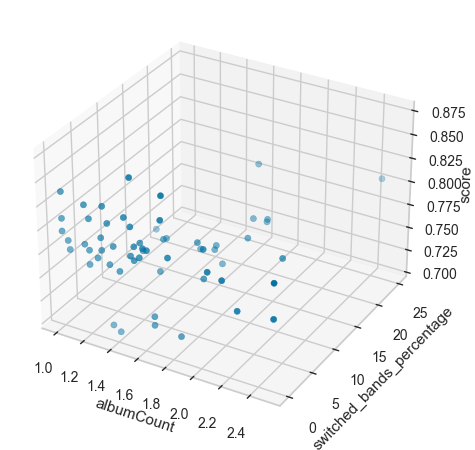

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(encodedClassConcat3['albumCount'], encodedClassConcat3['switched_bands_percentage'], encodedClassConcat3['score'], c='b', marker='o')

# Añadir etiquetas
ax.set_xlabel('albumCount')
ax.set_ylabel('switched_bands_percentage')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

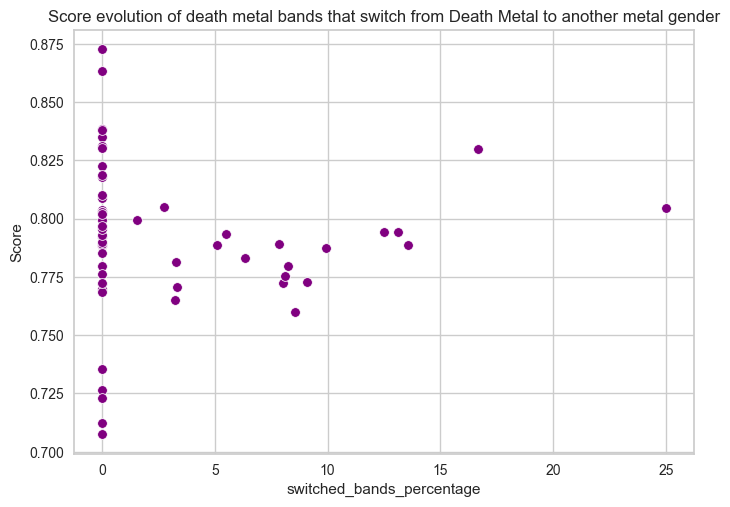

In [159]:
fig = sns.scatterplot(data=encodedClassConcat3, x="switched_bands_percentage", y="score", color='purple',ci=None)  
plt.title('Score evolution of death metal bands that switch from Death Metal to another metal gender') 
plt.xlabel('switched_bands_percentage')  
plt.ylabel('Score')  
plt.show()

In [160]:
ceros=(encodedClassConcat3['switched_bands_percentage']==0).sum()

In [161]:
ceros

40

In [162]:
len(encodedClassConcat3)

60

In [163]:
encodedClassConcat

,country,score,country_encoded,albumCount
0,Andorra,0.771824,0.785469,1
1,Argentina,0.779565,0.783038,1
2,Australia,0.788580,0.788580,1
3,Austria,0.801807,0.799022,1
4,Belarus,0.838333,0.798564,1
5,Belgium,0.803641,0.802540,1
6,Bosnia and Herzegovina,0.818000,0.793248,1
7,Brazil,0.770483,0.770499,1
8,Bulgaria,0.808889,0.791912,1
9,Canada,0.799242,0.799242,1


In [164]:
encodedClassMeans=encodedClassConcat[['score','albumCount','country_encoded']]

In [165]:
xCod = encodedClassMeans[['albumCount', 'country_encoded']].values  # Variables independientes
yCod = encodedClassMeans['score'].values 

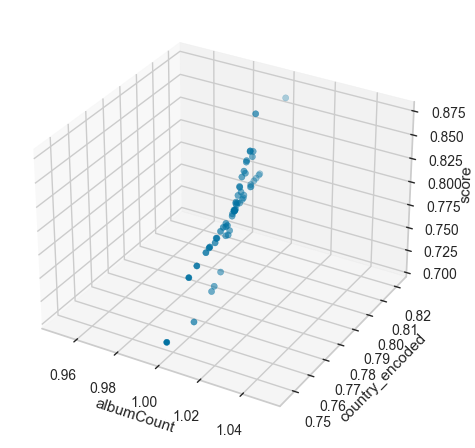

In [166]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(encodedClassMeans['albumCount'], encodedClassMeans['country_encoded'], encodedClassMeans['score'], c='b', marker='o')

# Añadir etiquetas
ax.set_xlabel('albumCount')
ax.set_ylabel('country_encoded')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

In [167]:
classMeansEN=classConcatEn[['score','albumCount','country_encoded']]
classMeansEN

,score,albumCount,country_encoded
0,0.500000,1,0.788580
1,0.770000,1,0.793552
2,0.860000,2,0.772478
3,0.783333,1,0.779656
4,0.650000,3,0.779656
...,...,...,...
4317,0.825000,1,0.775581
4318,0.804167,2,0.772935
4320,0.760000,1,0.787238
4321,0.861250,4,0.777402


In [168]:
xen = classMeansEN[['albumCount', 'country_encoded']].values  # Variables independientes
yen = classMeansEN['score'].values 

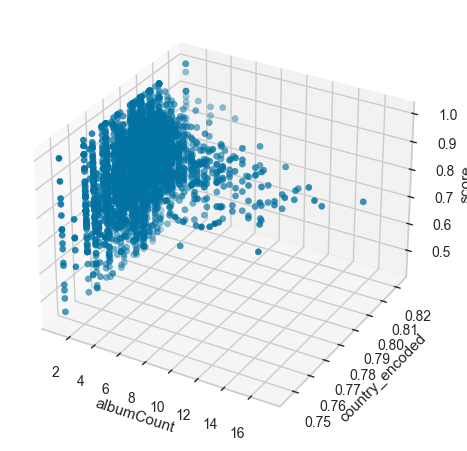

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Realizar el gráfico de dispersión
ax.scatter(classMeansEN['albumCount'], classMeansEN['country_encoded'], classMeansEN['score'], c='b', marker='o')

# Añadir etiquetas
ax.set_xlabel('albumCount')
ax.set_ylabel('country_encoded')
ax.set_zlabel('score')

# Mostrar el gráfico
plt.show()

In [170]:
classMeansLR

,score,albumCount,prob
0,0.500000,1,0.666667
1,0.770000,1,0.686275
2,0.860000,2,0.800000
3,0.783333,1,0.753623
4,0.650000,3,0.753623
...,...,...,...
4317,0.825000,1,0.700000
4318,0.804167,2,0.690141
4320,0.760000,1,0.705202
4321,0.861250,4,0.650000


In [171]:
xlr = classMeansLR[['albumCount', 'prob']].values  # Variables independientes
ylr = classMeansLR['score'].values 

In [172]:
xlr

array([[1.        , 0.66666667],
       [1.        , 0.68627451],
       [2.        , 0.8       ],
       ...,
       [1.        , 0.70520231],
       [4.        , 0.65      ],
       [1.        , 0.73232908]])

In [173]:
ylr

array([0.5    , 0.77   , 0.86   , ..., 0.76   , 0.86125, 0.93   ])

In [174]:
# Dividiendo el conjunto de datos en conjuntos de entrenamiento y prueba
X_trainLr, X_testLr, y_trainLr, y_testLr = train_test_split(xlr, ylr, test_size=0.2, random_state=2)

# Crear el modelo de regresión lineal
lr = LinearRegression()

# Ajustar el modelo con los datos de entrenamiento
lr.fit(X_trainLr, y_trainLr)

# Hacer predicciones en el conjunto de prueba
y_predLr = lr.predict(X_testLr)

# Aquí podrías continuar con la evaluación del modelo, etc.

In [175]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_testLr,y_predLr))

MAE 0.0844896781908235


In [176]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_testLr,y_predLr))

MSE 0.011877488607845163


In [177]:
print("RMSE",np.sqrt(mean_squared_error(y_testLr,y_predLr)))

RMSE 0.10898389150624584


In [178]:
from sklearn.metrics import r2_score
r2 = r2_score(y_testLr,y_predLr)
print(r2)

0.017455964772993937


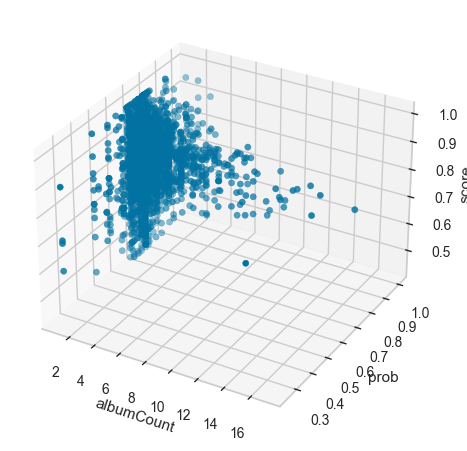

In [179]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_trainLr[:, 0], X_trainLr[:, 1], y_trainLr, c='b', marker='o')

ax.set_xlabel('albumCount')
ax.set_ylabel('prob')
ax.set_zlabel('score')

plt.show()

R^2: 0.9952169823731706


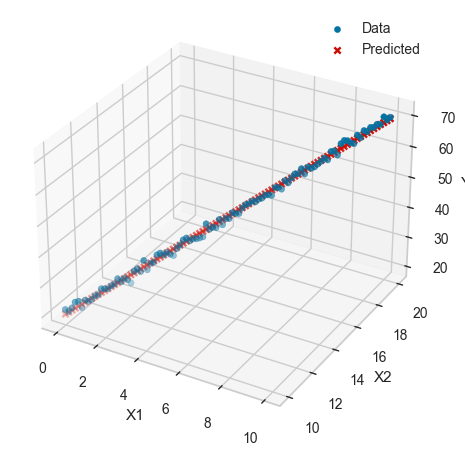

In [180]:

# Generar datos
np.random.seed(0)
n = 100
x1 = np.linspace(0, 10, n)
x2 = np.linspace(10, 20, n)
y = 3*x1 + 2*x2 + np.random.normal(0, 1, n)

# Crear matriz de características
X = np.column_stack((x1, x2))

# Ajustar modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Realizar predicciones
y_pred = model.predict(X)

# Calcular R^2
r2 = r2_score(y, y_pred)
print(f'R^2: {r2}')

# Crear gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Puntos de datos originales
ax.scatter(x1, x2, y, c='b', marker='o', label='Data')

# Puntos de datos predichos
ax.scatter(x1, x2, y_pred, c='r', marker='x', label='Predicted')

# Etiquetas de los ejes
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Leyenda
ax.legend()

plt.show()

In [181]:
print(X.shape)
print(y.shape)


(100, 2)
(100,)


In [182]:
nan_count = classMeansLR['score'].isna().sum()
print(f"El número de valores NaN en la columna 'score' es: {nan_count}")


El número de valores NaN en la columna 'score' es: 0


In [183]:
nan_count2 = classMeansLR['prob'].isna().sum()
print(f"El número de valores NaN en la columna 'prob' es: {nan_count}")

El número de valores NaN en la columna 'prob' es: 0


In [184]:
nan_count3 = classMeansLR['albumCount'].isna().sum()
print(f"El número de valores NaN en la columna 'albumCount' es: {nan_count}")

El número de valores NaN en la columna 'albumCount' es: 0


In [185]:
len(classMeansLR['score'])

4193

In [186]:
len(classMeansLR['prob'])

4193

In [187]:
len(classMeansLR['albumCount'])

4193

In [188]:
np.isinf(classMeansLR).sum()

score         0
albumCount    0
prob          0
dtype: int64

In [189]:
classMeansLR.duplicated().sum()

1530

In [190]:
classMeansLR['score'].dtype

dtype('float64')

In [191]:
classMeansLR['prob'].dtype

dtype('float64')

In [192]:
classMeansLR['albumCount'].dtype

dtype('int64')

In [193]:
print(X.shape)
print(y.shape)


(100, 2)
(100,)


In [194]:
y

array([21.76405235, 20.90520771, 21.98883899, 23.75604471, 23.88776001,
       21.54797465, 23.98039145, 23.38399633, 23.93718519, 24.95605305,
       25.19454862, 27.00982906, 26.82164379, 26.68733158, 27.5145703 ,
       27.9094319 , 29.57488715, 28.38070032, 29.40397679, 28.74186386,
       27.54802029, 31.2596792 , 31.97554731, 30.8739966 , 34.39096675,
       31.17189695, 33.17707165, 33.44917979, 35.67419336, 36.11582342,
       35.30646258, 36.03472818, 35.27383041, 34.6858702 , 36.82380502,
       37.83311665, 39.41210886, 39.88924854, 38.80459237, 39.39466695,
       39.15346724, 39.28705277, 39.50585102, 43.66794711, 41.71257004,
       42.28919843, 41.97952787, 44.51486409, 42.62852639, 44.53473447,
       44.35705869, 46.14447826, 45.75182113, 45.58704458, 47.24454504,
       48.20610965, 48.34934551, 49.09035069, 48.6586072 , 49.43523863,
       49.63056986, 50.44852765, 50.49998503, 50.09189922, 52.50065847,
       52.42650189, 51.70313499, 54.30116609, 53.43613598, 54.90

In [195]:
np.isnan(X).sum()

0

In [196]:
np.isnan(y).sum()

0

In [197]:
len(X)

100

In [198]:
len(y)

100

In [199]:
len(x)

NameError: name 'x' is not defined

In [ ]:
len(y)